# Test validity partial step 4, with only 1 term varying : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (C_{approx} + B^T N^{-1} B)^{-1}  N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_LiteBIRD_64 import *
# from get_freq_maps_LiteBIRD_64_noc1 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(15, 2, 49152)
(15, 2, 49152)


In [3]:
instrument

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0        40.0    37.42    26.46  70.5    1.0  forecast   
1        50.0    33.46    23.66  58.5    1.0  forecast   
2        60.0    21.31    15.07  51.1    1.0  forecast   
3        68.0    16.87    11.93  47.1    1.0  forecast   
4        78.0    12.07     8.53  43.8    1.0  forecast   
5        89.0    11.30     7.99  41.5    1.0  forecast   
6       100.0     6.56     4.64  37.8    1.0  forecast   
7       119.0     4.58     3.24  33.6    1.0  forecast   
8       140.0     4.79     3.39  30.8    1.0  forecast   
9       166.0     5.57     3.94  28.9    1.0  forecast   
10      195.0     5.85     4.14  28.6    1.0  forecast   
11      235.0    10.79     7.63  24.7    1.0  forecast   
12      280.0    13.80     9.76  22.5    1.0  forecast   
13      337.0    21.95    15.52  20.9    1.0  forecast   
14      402.0    47.45    33.55  17.9    1.0  forecast   

                     reference       type  \
0   arXiv:2202.02773, Table 13  satellite   
1   arXiv:2202.02773, Table 13  satellite   
2   arXiv:2202.02773, Table 13  satellite   
3   arXiv:2202.02773, Table 13  satellite   
4   arXiv:2202.02773, Table 13  satellite   
5   arXiv:2202.02773, Table 13  satellite   
6   arXiv:2202.02773, Table 13  satellite   
7   arXiv:2202.02773, Table 13  satellite   
8   arXiv:2202.02773, Table 13  satellite   
9   arXiv:2202.02773, Table 13  satellite   
10  arXiv:2202.02773, Table 13  satellite   
11  arXiv:2202.02773, Table 13  satellite   
12  arXiv:2202.02773, Table 13  satellite   
13  arXiv:2202.02773, Table 13  satellite   
14  arXiv:2202.02773, Table 13  satellite   

                                                 note experiment  
0   Different instruments at the same freq were co...   LiteBIRD  
1   Different instruments at the same freq were co...   LiteBIRD  
2   Different instruments at the same freq were co...   LiteBIRD  
3   Different instruments at the same freq were co...   LiteBIRD  
4   Different instruments at the same freq were co...   LiteBIRD  
5   Different instruments at the same freq were co...   LiteBIRD  
6   Different instruments at the same freq were co...   LiteBIRD  
7   Different instruments at the same freq were co...   LiteBIRD  
8   Different instruments at the same freq were co...   LiteBIRD  
9   Different instruments at the same freq were co...   LiteBIRD  
10  Different instruments at the same freq were co...   LiteBIRD  
11  Different instruments at the same freq were co...   LiteBIRD  
12  Different instruments at the same freq were co...   LiteBIRD  
13  Different instruments at the same freq were co...   LiteBIRD  
14  Different instruments at the same freq were co...   LiteBIRD

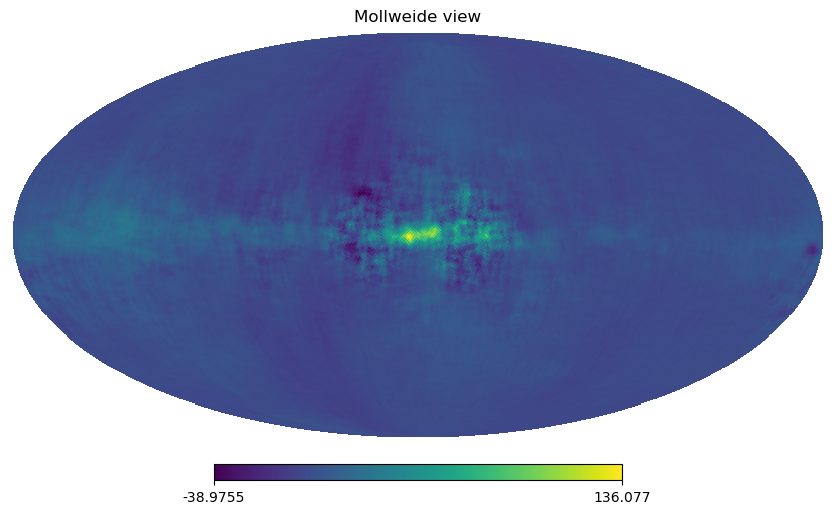

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
input_cmb_maps.shape

(15, 2, 49152)

In [7]:
r_chosen = 0
all_spectra = generate_power_spectra_CAMB(nside*2, r=r_chosen, typeless_bool=True)

lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]


Calculating spectra from CAMB !


In [8]:
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])
initial_spectra = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)
initial_spectra[0,:] = 0
initial_spectra[nstokes+2:,:] = 0

c_ells_input = np.zeros((6,lmax+1))
c_ell_approx = np.zeros((6,lmax+1))

c_ells_input[:4,...] = initial_spectra[:4,:]
c_ell_approx[1] = initial_spectra[1,:]
c_ell_approx[2] = initial_spectra[2,:]


# c_ells_input[1:3,...] = camb_cls.T[1:3]
# c_ell_approx[1] = camb_cls.T[1]
# c_ell_approx[2] = lensing_spectra.T[2]


In [9]:
indices_polar = np.array([1,2,4])

if nstokes == 2 and (c_ells_input.shape[0] != len(indices_polar)):    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])

# init_params_Clement = Clement_mixing_matrix[1:-1,1:]

init_param_pysm = init_mixing_matrix_obj.init_params()
init_params = init_mixing_matrix_obj.init_params()
# init_params = init_params_Clement


mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

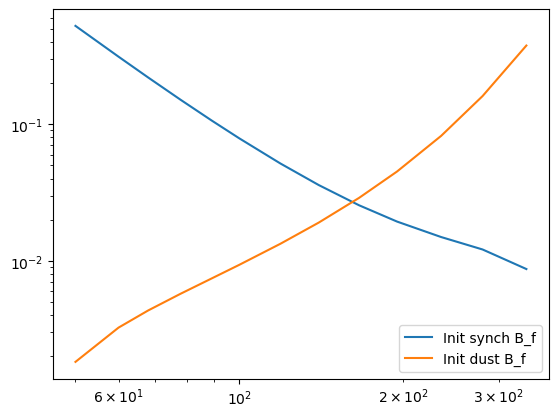

In [10]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, init_params[:,0], label='Init synch B_f')
plt.plot(frequency_Bf, init_params[:,1], label='Init dust B_f')
plt.legend()
plt.loglog()
plt.show()

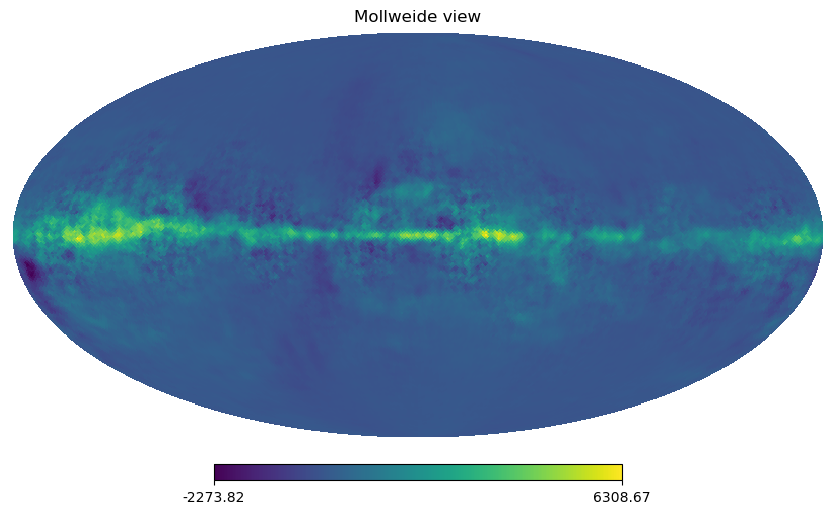

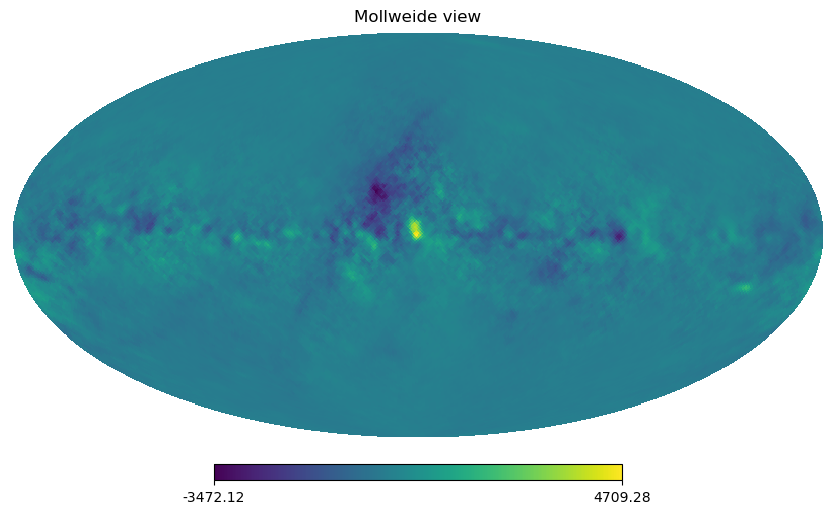

In [11]:
maps_cpnt = np.einsum('cf,fsp->csp', mixing_matrix_sampled.T, freq_maps)

hp.mollview(maps_cpnt[0][0])
hp.mollview(maps_cpnt[0][1])

In [12]:
# hp.mollview(maps_cpnt[1][0])
# hp.mollview(maps_cpnt[1][1])
# hp.mollview(maps_cpnt[2][0])
# hp.mollview(maps_cpnt[2][1])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [13]:
# eta_maps_v0_all_samples = np.zeros((number_samples, nstokes, npix))

# eta_maps = np.zeros((nstokes, npix))
# map_random_x = []
# map_random_y = []
# eta_maps_v0_all_samples[i,...] = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter)
# eta_maps_v0b = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter)


In [14]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []

eta_maps_v0 = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter)
# eta_maps_v0 = micmac.get_sampling_eta(param_dict, np.zeros_like(red_cov_approx_matrix), BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter)
# eta_maps = eta_maps_v0

eta_maps_v2 = micmac.get_sampling_eta_v2(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter)
# eta_maps_v2 = micmac.get_sampling_eta_v2(param_dict, np.zeros_like(red_cov_approx_matrix), BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter)
eta_maps = eta_maps_v2

eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
# eta_prime_maps = get_sampling_eta_prime(param_dict, np.zeros_like(red_cov_approx_matrix), BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

eta_maps_JAX = get_sampling_eta_JAX(number_frequencies, nstokes, nside, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=jnp.empty(0), map_random_y=jnp.empty(0), jax_key_PNRG=jax.random.PRNGKey(1), lmin=lmin, n_iter=n_iter)
# eta_maps_JAX = get_sampling_eta_JAX(number_frequencies, nstokes, nside, jnp.zeros_like(red_cov_approx_matrix), BtinvNB, BtinvN_sqrt, map_random_x=jnp.empty(0), map_random_y=jnp.empty(0), jax_key_PNRG=jax.random.PRNGKey(1), lmin=lmin, n_iter=n_iter)
eta_maps_JAX_array = jnp.asarray(eta_maps_JAX)

Recalculating x !
Recalculating y !
Recalculating x !
Recalculating y !
Recalculating x !
Recalculating y !
Recalculating x !
Recalculating y !
CPU times: user 5.5 s, sys: 949 ms, total: 6.45 s
Wall time: 3.05 s


In [15]:
covariance_noise = BtinvNB[0,0]*np.ones_like(c_ell_approx)


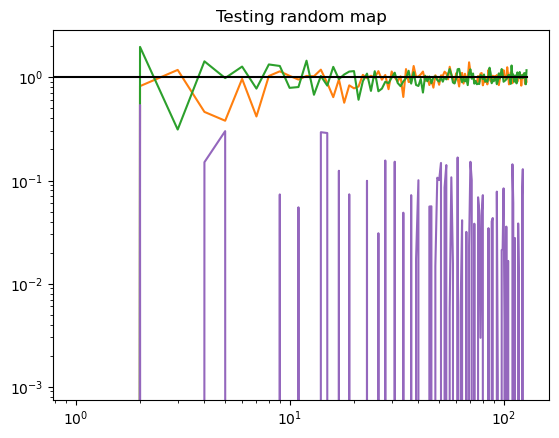

In [16]:
map_random_test = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))

map_random_ext = np.vstack([np.zeros_like(map_random_test[0]),map_random_test])
c_ell_random_test = hp.anafast(map_random_ext, lmax=lmax, iter=n_iter)

plt.plot(np.arange(c_ell_random_test.shape[-1]), c_ell_random_test.T)


plt.plot([0,lmax], [1,1], 'k')
plt.loglog()
plt.title("Testing random map")
plt.show()


In [17]:
eta_maps_v0.mean()

0.027085213502031403

In [18]:
((eta_maps_v0-eta_maps_v0.mean())*(eta_maps_v0-eta_maps_v0.mean())).sum()/(number_frequencies*12*nside**2)**2

0.00025758796868390884

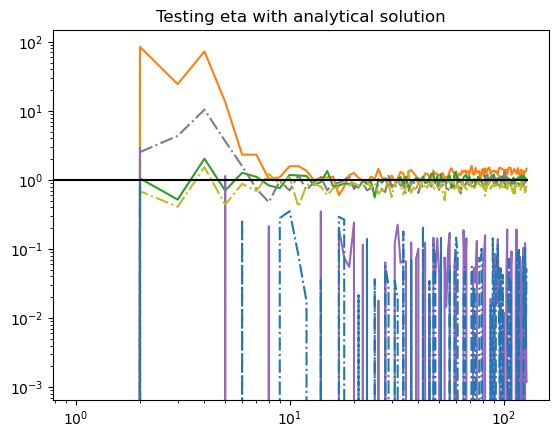

In [19]:
# eta_maps_ext = np.vstack([np.zeros_like(eta_maps_v0[0,0]),eta_maps_v0[0]])
eta_maps_v0_sum = np.sum(eta_maps_v0,axis=0)
eta_maps_ext = np.vstack([np.zeros_like(eta_maps_v0_sum[0]),eta_maps_v0_sum])


eta_maps_v2_ext = np.vstack([np.zeros_like(eta_maps_v2[0]),eta_maps_v2])
eta_maps_prime_ext = np.vstack([np.zeros_like(eta_prime_maps[0]),eta_prime_maps])
# eta_maps_JAX_ext = np.vstack([np.zeros_like(eta_maps_JAX_array[0]),eta_maps_JAX_array])


c_ell_eta = hp.anafast(eta_maps_ext, lmax=lmax, iter=n_iter)
c_ell_eta_v2 = hp.anafast(eta_maps_v2_ext, lmax=lmax, iter=n_iter)
# c_ell_eta_JAX = hp.anafast(eta_maps_JAX_ext, lmax=lmax, iter=n_iter)

c_ell_eta_prime = hp.anafast(eta_maps_prime_ext, lmax=lmax, iter=n_iter)


# plt.plot(np.arange(c_ell_eta.shape[-1]), c_ell_eta.T)
# plt.plot(np.arange(c_ell_eta.shape[-1]), (c_ell_eta/np.sqrt(covariance_noise[1])).T)
# plt.plot(np.arange(c_ell_eta_prime.shape[-1]), (c_ell_eta_prime/covariance_noise[1]).T)

plt.plot(np.arange(c_ell_eta.shape[-1]), c_ell_eta_v2.T)
plt.plot(np.arange(c_ell_eta.shape[-1]), c_ell_eta.T, '-.')

# plt.plot(np.arange(c_ell_eta_JAX.shape[-1]), c_ell_eta_JAX.T)

plt.plot([0,lmax], [1,1], 'k')
plt.loglog()
plt.title("Testing eta with analytical solution")
plt.show()

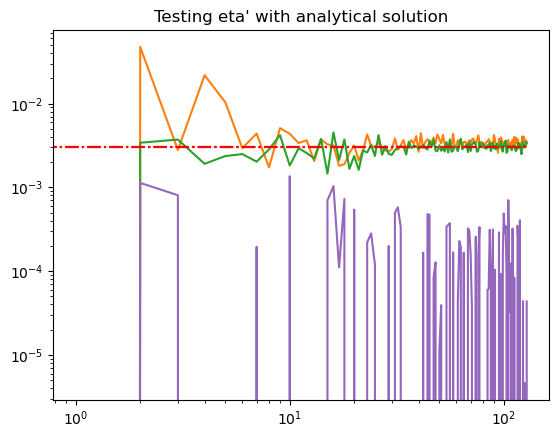

In [20]:
eta_maps_ext = np.vstack([np.zeros_like(eta_prime_maps[0]),eta_prime_maps])

c_ell_eta = hp.anafast(eta_maps_ext, lmax=lmax, iter=n_iter)

# covariance_noise = np.zeros_like(c_ell_approx)
# covariance_noise = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)
covariance_noise = BtinvNB[0,0]*np.ones_like(c_ell_approx)
analytical_eta_term = (np.zeros_like(c_ell_approx) + covariance_noise)#/np.sqrt(BtinvNB[0,0])

plt.plot(np.arange(c_ell_eta.shape[-1]), c_ell_eta.T)
plt.plot(np.arange(c_ell_approx.shape[-1]), analytical_eta_term.T, 'r-.')
# plt.plot([0,lmax], [1,1], 'k')
plt.loglog()
plt.title("Testing eta' with analytical solution")
plt.show()

## Mini-test

In [21]:
N_c_sqrt = jnp.einsum('ck,kf->cf', BtinvNB, BtinvN_sqrt)[0,...]

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))

covariance_1 = np.linalg.pinv(red_cov_approx_matrix + np.eye(nstokes)*BtinvNB[0,0])*BtinvNB[0,0]
covariance_2 = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_msqrt, np.linalg.pinv(np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0]), red_cov_approx_matrix_msqrt)
covariance_2_b = np.einsum('lij,ljk->lik', np.linalg.pinv(red_cov_approx_matrix), np.linalg.pinv(np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0]))

In [22]:
covariance_1.shape


(127, 2, 2)

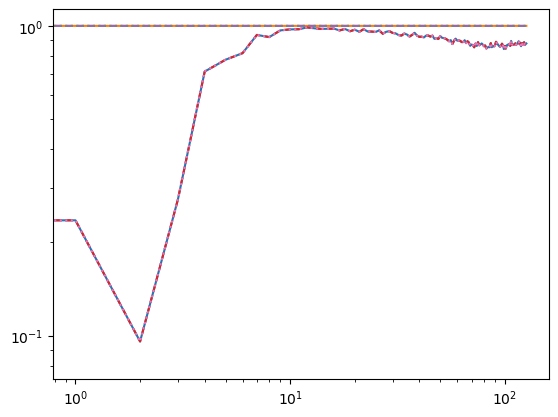

In [23]:
c_ell_cov_1 = micmac.get_c_ells_from_red_covariance_matrix(covariance_1)
c_ell_cov_2 = micmac.get_c_ells_from_red_covariance_matrix(covariance_2)
c_ell_cov_2_b = micmac.get_c_ells_from_red_covariance_matrix(covariance_2_b)

plt.plot(np.arange(c_ell_cov_1.shape[1]), c_ell_cov_1.T)
plt.plot(np.arange(c_ell_cov_1.shape[1]), c_ell_cov_2.T, '--')
plt.plot(np.arange(c_ell_cov_1.shape[1]), c_ell_cov_2_b.T, ':')
plt.loglog()
plt.show()

In [24]:
eta_maps_v2_ext = np.vstack([np.zeros_like(eta_maps_v2[0]),eta_maps_v2])

map_eta_modif_2a = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, covariance_2, nside=nside, lmin=lmin, n_iter=n_iter)
map_eta_modif_2b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, covariance_2_b, nside=nside, lmin=lmin, n_iter=n_iter)

print('2a :', np.einsum('sp,sp', eta_maps_v2, map_eta_modif_2a))
print('2b :', np.einsum('sp,sp', eta_maps_v2, map_eta_modif_2b))

2a : 140265374.73775652
2b : 140265374.73775652


# New generation of $\eta$

In [25]:
c_ells_covariance_1 = np.zeros((6,lmax+1))
indexes_polar = np.array([1,2,4])
c_ells_covariance_1[indexes_polar, lmin:] = micmac.get_c_ells_from_red_covariance_matrix(covariance_1)

alms_eta = hp.synalm(c_ells_covariance_1, lmax=lmax, new=True)
map_eta_to_test = hp.alm2map(alms_eta, nside=nside, lmax=lmax)[1:]

In [26]:
map_eta_to_test_2 = np.copy(eta_maps_v2)
covariance_unity = np.zeros((lmax+1,nstokes,nstokes))
covariance_unity[lmin:,...] = np.eye(nstokes)
map_eta_to_test = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(map_eta_to_test_2, covariance_unity, lmin=0, n_iter=n_iter)


In [27]:
N_c_msqrt = jnp.einsum('ck,kf->cf', BtinvNB, BtinvN_sqrt)[0,...]/BtinvNB[0,0]
generalisation_eta_test_freq = np.einsum('f,sp->fsp', N_c_msqrt, map_eta_to_test)*np.sqrt(BtinvNB[0,0])

In [28]:
# generalisation_eta_test_freq = np.copy(eta_maps_v0)
# map_eta_to_test = np.einsum('f,fsp->sp', N_c_sqrt, generalisation_eta_test_freq)/np.sqrt(BtinvNB[0,0])

In [29]:
N_c_sqrt = np.einsum('ck,kf->cf', BtinvNB, BtinvN_sqrt)[0,...]
eta_reformed = np.einsum('f,fsp->sp', N_c_sqrt, generalisation_eta_test_freq)
map_eta_to_test_ext = np.vstack([np.zeros_like(map_eta_to_test[0]),map_eta_to_test])
eta_reformed_ext = np.vstack([np.zeros_like(eta_reformed[0]),eta_reformed])


map_test_1 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_reformed_ext, np.linalg.pinv(red_cov_approx_matrix + np.eye(nstokes)*BtinvNB[0,0]), nside=nside, lmin=lmin, n_iter=n_iter)
map_test_2 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(map_eta_to_test_ext, covariance_2, nside=nside, lmin=lmin, n_iter=n_iter)

print('Log-proba 1 :', np.einsum('sp,sp', eta_reformed, map_test_1)/2)
print('Log-proba 2 :', np.einsum('sp,sp', map_eta_to_test, map_test_2)/2)


Log-proba 1 : 70132687.36872138
Log-proba 2 : 70132687.3687213


# Computation log-proba of the $\eta$ term

In [30]:
# s_c_map_extended = np.zeros((number_components, nstokes, npix))
# s_c_map_extended[0,...] = s_c_map
s_cML = np.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN, freq_maps)[0,...]

full_current_mixing_matrix = mixing_matrix_obj.get_B()

# full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)
full_data_without_CMB = freq_maps - s_cML

In [31]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(BtinvNB)))

[[2.15778848e+00 1.41382230e+00 2.07406460e+00 2.33265047e+00
  3.13096400e+00 2.51561888e+00 5.53361639e+00 7.43210900e+00
  4.72172691e+00 2.48551814e+00 1.71125400e+00 3.87691792e-01
  1.92212053e-01 5.46578266e-02 0.00000000e+00]
 [0.00000000e+00 4.92324943e-03 2.16177225e-02 4.60365073e-02
  1.19168003e-01 1.76098174e-01 6.56820214e-01 1.92089946e+00
  2.51066900e+00 2.81314146e+00 3.98028229e+00 2.13261451e+00
  2.54826415e+00 2.35897465e+00 1.34197369e+00]] (2, 15) (15, 2, 49152)
d-Bcsc -- mean 9.047848732532392 max 3458.044830905281 min -1966.229367528871
B_fN^{-1} (d-Bcsc) - mean 143.0474123943087 max 10961.965376671671 min -6210.724103924078
B_fN^{-1} - mean 1.8925059308750989 max 7.432109002386343 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.10904713543464677 max 0.3216545849529936 min -0.028895670754808395
(B_f^t N^{-1} B_f)^{-1} - mean -8.702779026479945


In [32]:
# regularization_constant = 0# -10**(12)

In [33]:
@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
def get_conditional_proba_spectral_likelihood_JAX(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)
    cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)

    return -(-first_term_complete + 0)/2.


In [54]:
@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
def get_conditional_proba_perturbation_likelihood_JAX_v1_fast(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    new_BtinvN_sqrt = micmac.get_BtinvN(jnp.array(jsp.linalg.sqrtm(freq_inverse_noise), dtype=jnp.float64), complete_mixing_matrix, jax_use=True)

    N_c_sqrt = jnp.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
    modified_sample_eta_maps_2 = jnp.einsum('f,fsp->sp', N_c_sqrt, modified_sample_eta_maps)

    # effective_harmonic_operator = jnp.linalg.pinv(1/new_BtinvNB[0,0] + jnp.linalg.pinv(red_cov_approx_matrix))
    
    # effective_harmonic_operator = jnp.linalg.pinv(jnp.eye(nstokes)*new_BtinvNB[0,0] + red_cov_approx_matrix)
    effective_harmonic_operator = jnp.linalg.pinv(jnp.eye(nstokes)*new_BtinvNB[0,0] + red_cov_approx_matrix)#*new_BtinvNB[0,0]
    central_term_eta_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_sample_eta_maps_2.reshape((nstokes,12*nside**2)), effective_harmonic_operator, nside=nside, lmin=lmin, n_iter=n_iter)
    # And finally \eta^t (C_approx^{1/2] (C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1} )^{-1} C_approx^{1/2] \eta
    second_term_complete = jnp.einsum('sk,sk', modified_sample_eta_maps_2, central_term_eta_maps.reshape(nstokes,12*nside**2))

    return -(-0 + second_term_complete)/2.

def get_conditional_proba_perturbation_likelihood_JAX_v1_slow(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    new_BtinvN_sqrt = micmac.get_BtinvN(jnp.array(jsp.linalg.sqrtm(freq_inverse_noise), dtype=jnp.float64), complete_mixing_matrix, jax_use=True)

    N_c_sqrt = jnp.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
    modified_sample_eta_maps_2 = jnp.einsum('f,fsp->sp', N_c_sqrt, modified_sample_eta_maps)

    # operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    # operator_pixel = 1/new_BtinvNB[0,0]
    operator_harmonic = red_cov_approx_matrix
    operator_pixel = new_BtinvNB[0,0]
    first_term_left = lambda x : micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(x.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside, lmin=lmin, n_iter=n_iter)
    def second_term_left(x, operator_pixel=operator_pixel):
        return operator_pixel*x.reshape((nstokes,12*nside**2))
        # return jnp.reshape(operator_pixel*x,(nstokes,12*nside**2),order='F')

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    initial_guess = jnp.zeros((nstokes,12*nside**2))
    right_member = jnp.copy(modified_sample_eta_maps_2)    
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)
    if with_prints:
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")

    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    second_term_complete = jnp.einsum('sk,sk', modified_sample_eta_maps_2, inverse_term.reshape(nstokes,12*nside**2))

    return -(-0 + second_term_complete)/2.

def get_conditional_proba_perturbation_likelihood_v1_slow_e(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=False)
    new_BtinvN_sqrt = micmac.get_BtinvN(np.array(scipy.linalg.sqrtm(freq_inverse_noise), dtype=np.float64), complete_mixing_matrix, jax_use=False)

    N_c_sqrt = np.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
    modified_sample_eta_maps_2 = np.einsum('f,fsp->sp', N_c_sqrt, modified_sample_eta_maps)#/new_BtinvNB[0,0]
    # modified_sample_eta_maps_2 = jnp.copy(modified_sample_eta_maps)

    # operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    # operator_pixel = 1/new_BtinvNB[0,0]
    operator_harmonic = red_cov_approx_matrix
    operator_pixel = new_BtinvNB[0,0]
    first_term_left = lambda x : micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(x.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside,lmin=lmin, n_iter=n_iter)
    def first_term_left(x):
        x_mNc_sqrt = np.einsum('f,fsp->sp', N_c_sqrt/new_BtinvNB[0,0], x.reshape((number_frequencies,nstokes,12*nside**2)))
        new_x_mNc_sqrt = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(x_mNc_sqrt.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside, lmin=lmin, n_iter=n_iter)
        return np.einsum('f,sp->fsp', N_c_sqrt/new_BtinvNB[0,0], new_x_mNc_sqrt).ravel()

    def second_term_left(x, operator_pixel=operator_pixel):
        return x.reshape((number_frequencies,nstokes,12*nside**2))
        # return operator_pixel*x.reshape((number_frequencies,nstokes,12*nside**2))

    func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()

    initial_guess = np.zeros((number_frequencies,nstokes,12*nside**2))
    # right_member = np.copy(modified_sample_eta_maps_2).ravel()
    right_member = np.copy(modified_sample_eta_maps).ravel()
    # inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)
    inverse_term, number_iterations, exit_code = generalized_cg_from_func(initial_guess.ravel(), func_left_term, right_member, limit_iter_cg=limit_iter_cg, tolerance=tolerance)
    if with_prints:
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")

    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    # second_term_complete = np.einsum('sk,sk', modified_sample_eta_maps_2, inverse_term.reshape(nstokes,12*nside**2))
    second_term_complete = np.einsum('fsk,fsk', modified_sample_eta_maps, inverse_term.reshape((number_frequencies,nstokes,12*nside**2)))
    return -(-0 + second_term_complete)/2.

def get_conditional_proba_perturbation_likelihood_v1_slow(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=False)
    new_BtinvN_sqrt = micmac.get_BtinvN(np.array(scipy.linalg.sqrtm(freq_inverse_noise), dtype=np.float64), complete_mixing_matrix, jax_use=False)

    N_c_sqrt = np.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
    modified_sample_eta_maps_2 = np.einsum('f,fsp->sp', N_c_sqrt, modified_sample_eta_maps)#/new_BtinvNB[0,0]
    # modified_sample_eta_maps_2 = jnp.copy(modified_sample_eta_maps)

    # operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    # operator_pixel = 1/new_BtinvNB[0,0]
    operator_harmonic = red_cov_approx_matrix
    operator_pixel = new_BtinvNB[0,0]
    first_term_left = lambda x : micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(x.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside, lmin=lmin, n_iter=n_iter)
    def second_term_left(x, operator_pixel=operator_pixel):
        return operator_pixel*x.reshape((nstokes,12*nside**2))

    func_left_term = lambda x : first_term_left(x).ravel() + second_term_left(x).ravel()

    initial_guess = np.zeros((nstokes,12*nside**2))
    right_member = np.copy(modified_sample_eta_maps_2).ravel()
    # inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)
    inverse_term, number_iterations, exit_code = generalized_cg_from_func(initial_guess.ravel(), func_left_term, right_member, limit_iter_cg=limit_iter_cg, tolerance=tolerance)
    if with_prints:
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")

    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    second_term_complete = np.einsum('sk,sk', modified_sample_eta_maps_2, inverse_term.reshape(nstokes,12*nside**2))
    # second_term_complete = np.einsum('fsp,f,sp', modified_sample_eta_maps, N_c_sqrt, inverse_term.reshape(nstokes,12*nside**2))

    return -(-0 + second_term_complete)/2.

def get_conditional_proba_perturbation_likelihood_JAX_v2_slow(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # new_BtinvN_sqrt = micmac.get_BtinvN(jnp.array(jsp.linalg.sqrtm(freq_inverse_noise), dtype=jnp.float64), complete_mixing_matrix, jax_use=True)

    # N_c_sqrt = jnp.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,:]
    # modified_sample_eta_maps_2 = np.copy(modified_sample_eta_maps)
    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))
    modified_sample_eta_maps_2 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_sample_eta_maps, red_cov_approx_matrix_msqrt, nside=nside, lmin=lmin, n_iter=n_iter)

    operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    operator_pixel = 1/new_BtinvNB[0,0]
    # operator_harmonic = red_cov_approx_matrix
    # operator_pixel = new_BtinvNB[0,0]
    first_term_left = lambda x : micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(x.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside, lmin=lmin, n_iter=n_iter)
    def second_term_left(x, operator_pixel=operator_pixel):
        return operator_pixel*x.reshape((nstokes,12*nside**2))

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    initial_guess = jnp.zeros((nstokes,12*nside**2))
    right_member = jnp.copy(modified_sample_eta_maps_2)    
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)
    if with_prints:
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")

    modified_sample_eta_maps_3 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(inverse_term.reshape(nstokes,12*nside**2), red_cov_approx_matrix_msqrt, nside=nside, lmin=lmin, n_iter=n_iter)


    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    second_term_complete = jnp.einsum('sk,sk', modified_sample_eta_maps, modified_sample_eta_maps_3)

    return -(-0 + second_term_complete)/2.

def get_conditional_proba_perturbation_likelihood_JAX_v2_d_fast(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=True)

    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))
    # new_BtinvN_sqrt = micmac.get_BtinvN(jnp.array(jsp.linalg.sqrtm(freq_inverse_noise), dtype=jnp.float64), complete_mixing_matrix, jax_use=True)

    # N_c_sqrt = jnp.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
    # modified_sample_eta_maps_2 = np.copy(modified_sample_eta_maps)
    modified_sample_eta_maps_2 = maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_sample_eta_maps, red_cov_approx_matrix_msqrt, nside=nside, lmin=lmin, n_iter=n_iter)

    effective_harmonic_operator = jnp.linalg.pinv(jnp.eye(nstokes)/new_BtinvNB[0,0] + jnp.linalg.pinv(red_cov_approx_matrix))
    # effective_harmonic_operator = jnp.linalg.pinv(new_BtinvNB[0,0] + red_cov_approx_matrix)
    central_term_eta_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_sample_eta_maps_2.reshape((nstokes,12*nside**2)), effective_harmonic_operator, nside=nside, lmin=lmin, n_iter=n_iter)
    
    modified_sample_eta_maps_3 = maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(central_term_eta_maps.reshape(nstokes,12*nside**2), red_cov_approx_matrix_msqrt, nside=nside, lmin=lmin, n_iter=n_iter)

    # And finally \eta^t (C_approx^{1/2] (C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1} )^{-1} C_approx^{1/2] \eta
    second_term_complete = jnp.einsum('sk,sk', modified_sample_eta_maps, modified_sample_eta_maps_3)

    return -(-0 + second_term_complete)/2.




def get_conditional_proba_perturbation_likelihood_JAX_v2_c_fast(complete_mixing_matrix, full_data_without_CMB, modified_sample_eta_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix, jax_use=True)

    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))
    # new_BtinvN_sqrt = micmac.get_BtinvN(jnp.array(jsp.linalg.sqrtm(freq_inverse_noise), dtype=jnp.float64), complete_mixing_matrix, jax_use=True)

    # N_c_sqrt = jnp.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
    modified_sample_eta_maps_2 = jnp.copy(modified_sample_eta_maps)
    # modified_sample_eta_maps_2 = maps_x_reduced_matrix_generalized_sqrt_sqrt(modified_sample_eta_maps, red_cov_approx_matrix_msqrt, lmin=lmin, n_iter=n_iter)

    effective_harmonic_operator = jnp.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_msqrt, jnp.linalg.pinv(jnp.eye(nstokes)/new_BtinvNB[0,0] + jnp.linalg.pinv(red_cov_approx_matrix)), red_cov_approx_matrix_msqrt)
    # effective_harmonic_operator = jnp.linalg.pinv(new_BtinvNB[0,0] + red_cov_approx_matrix)
    central_term_eta_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_sample_eta_maps_2.reshape((nstokes,12*nside**2)), effective_harmonic_operator, nside=nside, lmin=lmin, n_iter=n_iter)
    # And finally \eta^t (C_approx^{1/2] (C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1} )^{-1} C_approx^{1/2] \eta
    second_term_complete = jnp.einsum('sk,sk', modified_sample_eta_maps_2, central_term_eta_maps.reshape(nstokes,12*nside**2))

    return -(-0 + second_term_complete)/2.

def new_get_conditional_proba_perturbation_likelihood_JAX_old(value_param_mixing_matrix, freq_param, cpt_param, pos_special_freqs=[0,-1], option='', **model_kwargs):
    params_mixing_matrix = jnp.copy(init_params)
    params_mixing_matrix = params_mixing_matrix.at[freq_param,cpt_param].set(value_param_mixing_matrix)
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    if option=='v1_fast':
        return get_conditional_proba_perturbation_likelihood_JAX_v1_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    elif option=='v1_slow':
        return get_conditional_proba_perturbation_likelihood_JAX_v1_slow(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    elif option=='v2_c_fast':
        return get_conditional_proba_perturbation_likelihood_JAX_v2_c_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    elif option=='v2_d_fast':
        return get_conditional_proba_perturbation_likelihood_JAX_v2_d_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    elif option=='v2_slow':
        return get_conditional_proba_perturbation_likelihood_JAX_v2_slow(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    raise Exception('Option not well defined !!')
    # return get_conditional_proba_perturbation_likelihood_JAX_v0_capprox0(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])

def new_get_conditional_proba_perturbation_likelihood_JAX(value_param_mixing_matrix, freq_param, cpt_param, pos_special_freqs=[0,-1], option='', **model_kwargs):
    params_mixing_matrix = jnp.copy(init_params)
    params_mixing_matrix = params_mixing_matrix.at[freq_param,cpt_param].set(value_param_mixing_matrix)
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    return get_conditional_proba_perturbation_likelihood_JAX_v1_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])




def new_get_conditional_proba_spectral_likelihood_JAX(value_param_mixing_matrix, freq_param, cpt_param, pos_special_freqs=[0,-1], **model_kwargs):
    # freq_param, cpt_param #= components_single_param
    params_mixing_matrix = jnp.copy(init_params)
    # print("Test", freq_param, cpt_param)
    params_mixing_matrix = params_mixing_matrix.at[freq_param,cpt_param].set(value_param_mixing_matrix)
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    return get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['modified_sample_eta_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])

def new_get_conditional_proba_full_likelihood_JAX(value_param_mixing_matrix, freq_param, cpt_param, pos_special_freqs=[0,-1], option='v1_fast', **model_kwargs):
    # freq_param, cpt_param #= components_single_param
    params_mixing_matrix = jnp.copy(init_params)
    # print("Test", freq_param, cpt_param)
    # # print("Test", freq_param, cpt_param, value_param_mixing_matrix, params_mixing_matrix, flush=True)
    params_mixing_matrix = params_mixing_matrix.at[freq_param,cpt_param].set(value_param_mixing_matrix)
    # print("Test2 ", params_mixing_matrix, flush=True)
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    # print("Test3 ", new_mixing_matrix, flush=True)

    log_proba_spectral_likelihood = get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    # log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX_v1_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    # elif option=='v1_slow':
    #     log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX_v1_slow(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    # elif option=='v2_c_fast':
    #     log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX_v2_c_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    # elif option=='v2_d_fast':
    #     log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX_v2_d_fast(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    # elif option=='v2_slow':
    #     log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX_v2_slow(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    
    # log_proba_perturbation_likelihood = get_conditional_proba_perturbation_likelihood_JAX_v0_capprox0(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), model_kwargs['modified_sample_eta_maps'], freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'])
    return log_proba_spectral_likelihood + log_proba_perturbation_likelihood


In [55]:
# First applying C_{approx}^{-1/2}
# modified_sample_eta_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps, jnp.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)), nside=nside, lmin=lmin, n_iter=n_iter)


modified_sample_eta_maps_v1 = np.copy(generalisation_eta_test_freq)
# modified_sample_eta_maps_v2 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(map_eta_to_test, np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)), lmin=lmin, n_iter=n_iter)
modified_sample_eta_maps_v2 = np.copy(map_eta_to_test)

# eta_maps_v0_comp = eta_maps_v0.sum(axis=0)
# modified_sample_eta_maps_v2b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(eta_maps_v0_comp, np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)), lmin=lmin, n_iter=n_iter)


In [56]:
freq_coord = 0
cpt_coord = 0

log_proba_v1_fast = new_get_conditional_proba_perturbation_likelihood_JAX_old(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, option='v1_fast', pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps_v1, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba_v1_slow = new_get_conditional_proba_perturbation_likelihood_JAX_old(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, option='v1_slow', pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps_v1, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba_v2_c_fast = new_get_conditional_proba_perturbation_likelihood_JAX_old(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, option='v2_c_fast', pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps_v2, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba_v2_d_fast = new_get_conditional_proba_perturbation_likelihood_JAX_old(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, option='v2_d_fast', pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps_v2, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba_v2_slow = new_get_conditional_proba_perturbation_likelihood_JAX_old(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, option='v2_slow', pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps_v2, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)


CG-Python-0 WF finished in  None iterations !!
CG-Python-0 WF finished in  None iterations !!


In [57]:
print("Log_proba : v1_fast", log_proba_v1_fast, "v1_slow", log_proba_v1_slow, "v2_c_fast", log_proba_v2_c_fast, "v2_slow", log_proba_v2_slow)
print("Log_proba : v2_d_fast", log_proba_v2_d_fast, "v2_d_slow")


Log_proba : v1_fast -70132687.3687208 v1_slow -70132687.36879908 v2_c_fast -70132687.36872073 v2_slow -70132687.36873384
Log_proba : v2_d_fast -70132687.36820804 v2_d_slow


True value : 57259764.22224595

2 x 114519528.4444919 


In [58]:
covariance_1 = np.linalg.pinv(red_cov_approx_matrix + np.eye(nstokes)*BtinvNB[0,0])*BtinvNB[0,0]
covariance_2 = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_msqrt, np.linalg.pinv(np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0]), red_cov_approx_matrix_msqrt)
covariance_2_b = np.einsum('lij,ljk->lik', np.linalg.pinv(red_cov_approx_matrix), np.linalg.pinv(np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0]))

covariance_1_extended = np.zeros((lmax+1,nstokes,nstokes))
covariance_1_extended[:lmin] = np.eye(nstokes)
covariance_1_extended[lmin:] = np.copy(covariance_1)
covariance_2_extended = np.zeros((lmax+1,nstokes,nstokes))
covariance_2_extended[:lmin] = np.eye(nstokes)*BtinvNB[0,0]
covariance_2_extended[lmin:] = np.copy(covariance_2)
covariance_2b_extended = np.zeros((lmax+1,nstokes,nstokes))
covariance_2b_extended[:lmin] = np.eye(nstokes)*BtinvNB[0,0]
covariance_2b_extended[lmin:] = np.copy(covariance_2_b)

# eta_maps_v0_sum = eta_maps_v0.sum(axis=0)
# eta_maps_v0_ext = np.vstack([np.zeros_like(eta_maps_v0_sum[0]),eta_maps_v0_sum])
eta_maps_v2_ext = np.vstack([np.zeros_like(map_eta_to_test[0]),map_eta_to_test])

modified_eta_test_v2 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, red_cov_approx_matrix_msqrt, nside=nside, lmin=lmin, n_iter=n_iter)
modified_eta_test_v2_ext = np.vstack([np.zeros_like(modified_eta_test_v2[0]),modified_eta_test_v2])


In [59]:

# map_eta_modif_0 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v0_ext, covariance_1, nside=nside, lmin=lmin, n_iter=n_iter)
# map_eta_modif_2a = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, covariance_2, nside=nside, lmin=lmin, n_iter=n_iter)
# map_eta_modif_2b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, covariance_2_b, nside=nside, lmin=lmin, n_iter=n_iter)
# map_eta_modif_0 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(eta_maps_v0_ext, covariance_1, lmin=lmin, n_iter=n_iter)
map_eta_modif_0a = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(eta_maps_v2_ext, covariance_1, lmin=lmin, n_iter=n_iter)
map_eta_modif_2a = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(eta_maps_v2_ext, covariance_2, lmin=lmin, n_iter=n_iter)
map_eta_modif_2b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(eta_maps_v2_ext, covariance_2_b, lmin=lmin, n_iter=n_iter)

map_eta_modif_2a_a = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_eta_test_v2_ext, np.linalg.pinv(np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0]), nside=nside, lmin=lmin, n_iter=n_iter)

# map_eta_modif_0_b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v0_ext, covariance_1_extended, nside=nside, lmin=0, n_iter=n_iter)
map_eta_modif_2a_b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, covariance_2_extended, nside=nside, lmin=0, n_iter=n_iter)
map_eta_modif_2b_b = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_maps_v2_ext, covariance_2b_extended, nside=nside, lmin=0, n_iter=n_iter)

# print('0 :', -np.einsum('sp,sp', eta_maps_v0_sum, map_eta_modif_0)/2)
print('0a :', -np.einsum('sp,sp', map_eta_to_test, map_eta_modif_0a)/2)
print('2a :', -np.einsum('sp,sp', map_eta_to_test, map_eta_modif_2a)/2)
print('2b :', -np.einsum('sp,sp', map_eta_to_test, map_eta_modif_2b)/2)

# print('2a_a :', -np.einsum('sp,sp', modified_eta_test_v2, map_eta_modif_2a_a)/2)

# print('0_ext :', -np.einsum('sp,sp', eta_maps_v0_sum, map_eta_modif_0_b)/2)
print('2a_ext :', -np.einsum('sp,sp', map_eta_to_test, map_eta_modif_2a_b)/2)
print('2b_ext :', -np.einsum('sp,sp', map_eta_to_test, map_eta_modif_2b_b)/2)

0a : -70132687.3687213
2a : -70132687.3687213
2b : -70132687.3687213
2a_ext : -70132687.3687213
2b_ext : -70132687.3687213


In [60]:
N_c_sqrt = np.einsum('ck,kf->cf', BtinvNB, BtinvN_sqrt)[0,...]
eta_reformed = np.einsum('f,fsp->sp', N_c_sqrt, generalisation_eta_test_freq)
map_eta_to_test_ext = np.vstack([np.zeros_like(map_eta_to_test[0]),map_eta_to_test])
eta_reformed_ext = np.vstack([np.zeros_like(eta_reformed[0]),eta_reformed])


map_test_1 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(eta_reformed_ext, np.linalg.pinv(red_cov_approx_matrix + np.eye(nstokes)*BtinvNB[0,0]), nside=nside, lmin=lmin, n_iter=n_iter)
map_test_2 = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(map_eta_to_test_ext, covariance_2, nside=nside, lmin=lmin, n_iter=n_iter)

print('Log-proba 1 :', np.einsum('sp,sp', eta_reformed, map_test_1)/2)
print('Log-proba 2 :', np.einsum('sp,sp', map_eta_to_test, map_test_2)/2)


Log-proba 1 : 70132687.36872138
Log-proba 2 : 70132687.3687213


In [61]:

new_BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_obj.get_B(), jax_use=False)
new_BtinvN_sqrt = micmac.get_BtinvN(np.array(scipy.linalg.sqrtm(freq_inverse_noise), dtype=jnp.float64), mixing_matrix_obj.get_B(), jax_use=False)

N_c_sqrt = jnp.einsum('ck,kf->cf', new_BtinvNB, new_BtinvN_sqrt)[0,...]
modified_sample_eta_maps_2 = np.einsum('f,fsp->sp', N_c_sqrt, generalisation_eta_test_freq)

# effective_harmonic_operator = jnp.linalg.pinv(1/new_BtinvNB[0,0] + jnp.linalg.pinv(red_cov_approx_matrix))

# effective_harmonic_operator = jnp.linalg.pinv(jnp.eye(nstokes)*new_BtinvNB[0,0] + red_cov_approx_matrix)
# effective_harmonic_operator = jnp.linalg.pinv(jnp.eye(nstokes)*new_BtinvNB[0,0] + red_cov_approx_matrix)#*new_BtinvNB[0,0]
# central_term_eta_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(modified_sample_eta_maps_2.reshape((nstokes,12*nside**2)), effective_harmonic_operator, nside=nside, lmin=lmin, n_iter=n_iter)
effective_harmonic_operator = np.linalg.pinv(np.eye(nstokes)*new_BtinvNB[0,0] + red_cov_approx_matrix)#*new_BtinvNB[0,0]
central_term_eta_maps = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(modified_sample_eta_maps_2.reshape((nstokes,12*nside**2)), effective_harmonic_operator, lmin=lmin, n_iter=n_iter)
# And finally \eta^t (C_approx^{1/2] (C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1} )^{-1} C_approx^{1/2] \eta
print('test log-proba', np.einsum('sk,sk', modified_sample_eta_maps_2, central_term_eta_maps.reshape(nstokes,12*nside**2))/2)


test log-proba 70132687.36872138


True value : 57259764.22224595

2 x 114519528.4444919 


In [62]:
jitted_new_get_conditional_proba_spectral_likelihood_JAX = jax.jit(new_get_conditional_proba_spectral_likelihood_JAX, static_argnames=['with_prints'])
jitted_new_get_conditional_proba_full_likelihood_JAX = jax.jit(new_get_conditional_proba_full_likelihood_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
jitted_new_get_conditional_proba_perturbation_likelihood_JAX = jax.jit(new_get_conditional_proba_perturbation_likelihood_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])

In [63]:
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v1_fast = jax.jit(get_conditional_proba_perturbation_likelihood_JAX_v1_fast, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v1_slow = jax.jit(get_conditional_proba_perturbation_likelihood_JAX_v1_slow, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v2_c_fast = jax.jit(get_conditional_proba_perturbation_likelihood_JAX_v2_c_fast, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v2_slow = jax.jit(get_conditional_proba_perturbation_likelihood_JAX_v2_slow, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v2_d_fast = jax.jit(get_conditional_proba_perturbation_likelihood_JAX_v2_d_fast, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])

In [64]:
%%time
with_prints_ = True
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v1_fast(mixing_matrix_sampled, full_data_without_CMB, modified_sample_eta_maps_v1, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints=with_prints_)


CPU times: user 901 ms, sys: 183 ms, total: 1.08 s
Wall time: 514 ms


Array(-70132687.3687208, dtype=float64)

In [65]:
%%time
with_prints_ = True
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v1_slow(mixing_matrix_sampled, full_data_without_CMB, modified_sample_eta_maps_v1, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints=with_prints_)


CG-Python-0 WF finished in  None iterations !!
CPU times: user 4.6 s, sys: 681 ms, total: 5.29 s
Wall time: 1.44 s


Array(-70132687.36879908, dtype=float64)

In [66]:
%%time
with_prints_ = True
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v2_c_fast(mixing_matrix_sampled, full_data_without_CMB, modified_sample_eta_maps_v2, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints=with_prints_)


CPU times: user 26.4 s, sys: 669 ms, total: 27.1 s
Wall time: 26.6 s


Array(-70132687.36872073, dtype=float64)

In [67]:
%%time
with_prints_ = True
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v2_slow(mixing_matrix_sampled, full_data_without_CMB, modified_sample_eta_maps_v2, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints=with_prints_)


CG-Python-0 WF finished in  None iterations !!
CPU times: user 1min 28s, sys: 8.2 s, total: 1min 37s
Wall time: 43.8 s


Array(-70132687.36873384, dtype=float64)

In [68]:
%%time
with_prints_ = True
jitted_new_get_conditional_proba_perturbation_likelihood_JAX_v2_d_fast(mixing_matrix_sampled, full_data_without_CMB, modified_sample_eta_maps_v2, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints=with_prints_)


CPU times: user 28.1 s, sys: 767 ms, total: 28.9 s
Wall time: 28.4 s


Array(-70132687.36820804, dtype=float64)

In [69]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel(order='F')
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
dimensions_mixing_matrix = 1

freq_coord = -1
cpt_coord = 0
components_single_param_coord = [freq_coord,cpt_coord]

initial_guess_fg_mixing_matrix = mixing_matrix_obj.params[freq_coord, cpt_coord]
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
full_initial_guess = np.copy(initial_guess_fg_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*10.05, size=(n_walkers,dimensions_mixing_matrix))

# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[0.52387813 0.00182426]
 [0.3117258  0.00324908]
 [0.21971687 0.00433627]
 [0.15096497 0.0057459 ]
 [0.10631274 0.0074421 ]
 [0.07881344 0.00935487]
 [0.05159725 0.0133358 ]
 [0.03585547 0.01906532]
 [0.02552178 0.02888587]
 [0.0193825  0.04508262]
 [0.01493871 0.08217483]
 [0.01211497 0.16061503]
 [0.00871575 0.37616284]] 0.00871575417230739


## Fisher

In [70]:
path_Fisher =  '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_sampling_step_4/fisher_litebird_d0s0_lmin2_lmax128_masked_Alens1.0_r0.0_B_noiselens_synchdust.txt'
Fisher_matrix = np.loadtxt(path_Fisher)

Fisher_matrix_diag = np.diag(Fisher_matrix)[:number_frequencies-2]

minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)

# minimum_std_Fisher_diag = np.zeros(minimum_std_Fisher.shape[0]-1)
# minimum_std_Fisher_diag[:number_frequencies-2] = np.diag(minimum_std_Fisher)[number_frequencies-2:-1]
# minimum_std_Fisher_diag[number_frequencies-2:] = np.diag(minimum_std_Fisher)[:number_frequencies-2]

In [71]:
np.diag(minimum_std_Fisher), minimum_std_Fisher_diag

(array([1.29324268e-03, 9.62148633e-04, 7.62460177e-04, 6.23283957e-04,
        5.36182447e-04, 4.29689251e-04, 3.62604834e-04, 2.96497747e-04,
        3.19329897e-04, 2.94524649e-04, 3.75601363e-04, 6.23341646e-04,
        1.02018086e-03, 4.95614237e-05, 3.68731309e-05, 2.92207210e-05,
        2.38873861e-05, 2.05496919e-05, 1.64688905e-05, 1.38983823e-05,
        1.13653364e-05, 1.22402409e-05, 1.12896537e-05, 1.43962019e-05,
        2.38896043e-05, 3.90970393e-05, 9.22799496e-05]),
 array([1.29324268e-03, 9.62148633e-04, 7.62460177e-04, 6.23283957e-04,
        5.36182447e-04, 4.29689251e-04, 3.62604834e-04, 2.96497747e-04,
        3.19329897e-04, 2.94524649e-04, 3.75601363e-04, 6.23341646e-04,
        1.02018086e-03, 4.95614237e-05, 3.68731309e-05, 2.92207210e-05,
        2.38873861e-05, 2.05496919e-05, 1.64688905e-05, 1.38983823e-05,
        1.13653364e-05, 1.22402409e-05, 1.12896537e-05, 1.43962019e-05,
        2.38896043e-05, 3.90970393e-05, 9.22799496e-05]))

In [72]:
minimum_std_Fisher_diag[:number_frequencies-2], minimum_std_Fisher_diag[number_frequencies-2:]

(array([0.00129324, 0.00096215, 0.00076246, 0.00062328, 0.00053618,
        0.00042969, 0.0003626 , 0.0002965 , 0.00031933, 0.00029452,
        0.0003756 , 0.00062334, 0.00102018]),
 array([4.95614237e-05, 3.68731309e-05, 2.92207210e-05, 2.38873861e-05,
        2.05496919e-05, 1.64688905e-05, 1.38983823e-05, 1.13653364e-05,
        1.22402409e-05, 1.12896537e-05, 1.43962019e-05, 2.38896043e-05,
        3.90970393e-05, 9.22799496e-05]))

## Fine griding

In [73]:
freq_coord = -1
minimum_std_Fisher_diag[freq_coord], init_params[freq_coord, 0]

(9.227994961524167e-05, 0.00871575417230739)

In [74]:
np.arange(-5,5,.2)

array([-5.0000000e+00, -4.8000000e+00, -4.6000000e+00, -4.4000000e+00,
       -4.2000000e+00, -4.0000000e+00, -3.8000000e+00, -3.6000000e+00,
       -3.4000000e+00, -3.2000000e+00, -3.0000000e+00, -2.8000000e+00,
       -2.6000000e+00, -2.4000000e+00, -2.2000000e+00, -2.0000000e+00,
       -1.8000000e+00, -1.6000000e+00, -1.4000000e+00, -1.2000000e+00,
       -1.0000000e+00, -8.0000000e-01, -6.0000000e-01, -4.0000000e-01,
       -2.0000000e-01,  4.4408921e-15,  2.0000000e-01,  4.0000000e-01,
        6.0000000e-01,  8.0000000e-01,  1.0000000e+00,  1.2000000e+00,
        1.4000000e+00,  1.6000000e+00,  1.8000000e+00,  2.0000000e+00,
        2.2000000e+00,  2.4000000e+00,  2.6000000e+00,  2.8000000e+00,
        3.0000000e+00,  3.2000000e+00,  3.4000000e+00,  3.6000000e+00,
        3.8000000e+00,  4.0000000e+00,  4.2000000e+00,  4.4000000e+00,
        4.6000000e+00,  4.8000000e+00])

In [75]:
modified_sample_eta_maps = modified_sample_eta_maps_v1

In [76]:
%%time 
# griding_logspace_broad = np.logspace(-4, 0, 50)
griding_logspace_broad = np.logspace(-3, -.1, 30)


# log_proba_griding = []
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace]
log_proba_samples_synch_list_broad = np.empty((number_frequencies-2, griding_logspace_broad.shape[-1]))
log_proba_samples_dust_list_broad = np.empty((number_frequencies-2, griding_logspace_broad.shape[-1]))
for freq_coord in range(number_frequencies-2):
    initial_value = init_params[freq_coord, 0]
    # griding_logspace_broad[0,freq_coord,...] = np.arange(-5,5,.2)*minimum_std_Fisher_diag[freq_coord] + initial_value
    log_proba_samples_synch_list_broad[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_broad])
    initial_value = init_params[freq_coord, 1]
    # griding_logspace_broad[1,freq_coord,...] = np.arange(-5,5,.2)*minimum_std_Fisher_diag[freq_coord + number_frequencies-2] + initial_value
    log_proba_samples_dust_list_broad[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_broad])


log_proba_samples_synch_full_proba_broad = np.empty((number_frequencies-2, griding_logspace_broad.shape[-1]))
log_proba_samples_synch_perturbation_proba_broad = np.empty((number_frequencies-2, griding_logspace_broad.shape[-1]))
log_proba_samples_dust_full_proba_broad = np.empty((number_frequencies-2, griding_logspace_broad.shape[-1]))
log_proba_samples_dust_perturbation_proba_broad = np.empty((number_frequencies-2, griding_logspace_broad.shape[-1]))
for freq_coord in range(number_frequencies-2):
    print("Nb freq :", freq_coord, number_frequencies-2)
    # log_proba_samples_synch_full_proba_broad[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_broad])
    print("Nb freq n°2 :", freq_coord, number_frequencies-2)
    # log_proba_samples_dust_full_proba_broad[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_broad])
    print("Nb freq n°3 :", freq_coord, number_frequencies-2)
    log_proba_samples_synch_perturbation_proba_broad[freq_coord,...] = np.array([jitted_new_get_conditional_proba_perturbation_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_broad])
    print("Nb freq n°4 :", freq_coord, number_frequencies-2)
    log_proba_samples_dust_perturbation_proba_broad[freq_coord,...] = np.array([jitted_new_get_conditional_proba_perturbation_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_broad])

log_proba_samples_synch_full_proba_broad = log_proba_samples_synch_perturbation_proba_broad + log_proba_samples_synch_list_broad
log_proba_samples_dust_full_proba_broad = log_proba_samples_dust_perturbation_proba_broad + log_proba_samples_dust_list_broad

Nb freq : 0 13
Nb freq n°2 : 0 13
Nb freq n°3 : 0 13
Nb freq n°4 : 0 13
Nb freq : 1 13
Nb freq n°2 : 1 13
Nb freq n°3 : 1 13
Nb freq n°4 : 1 13
Nb freq : 2 13
Nb freq n°2 : 2 13
Nb freq n°3 : 2 13
Nb freq n°4 : 2 13
Nb freq : 3 13
Nb freq n°2 : 3 13
Nb freq n°3 : 3 13
Nb freq n°4 : 3 13
Nb freq : 4 13
Nb freq n°2 : 4 13
Nb freq n°3 : 4 13
Nb freq n°4 : 4 13
Nb freq : 5 13
Nb freq n°2 : 5 13
Nb freq n°3 : 5 13
Nb freq n°4 : 5 13
Nb freq : 6 13
Nb freq n°2 : 6 13
Nb freq n°3 : 6 13
Nb freq n°4 : 6 13
Nb freq : 7 13
Nb freq n°2 : 7 13
Nb freq n°3 : 7 13
Nb freq n°4 : 7 13
Nb freq : 8 13
Nb freq n°2 : 8 13
Nb freq n°3 : 8 13
Nb freq n°4 : 8 13
Nb freq : 9 13
Nb freq n°2 : 9 13
Nb freq n°3 : 9 13
Nb freq n°4 : 9 13
Nb freq : 10 13
Nb freq n°2 : 10 13
Nb freq n°3 : 10 13
Nb freq n°4 : 10 13
Nb freq : 11 13
Nb freq n°2 : 11 13
Nb freq n°3 : 11 13
Nb freq n°4 : 11 13
Nb freq : 12 13
Nb freq n°2 : 12 13
Nb freq n°3 : 12 13
Nb freq n°4 : 12 13
CPU times: user 2min 14s, sys: 16.9 s, total: 2min 3

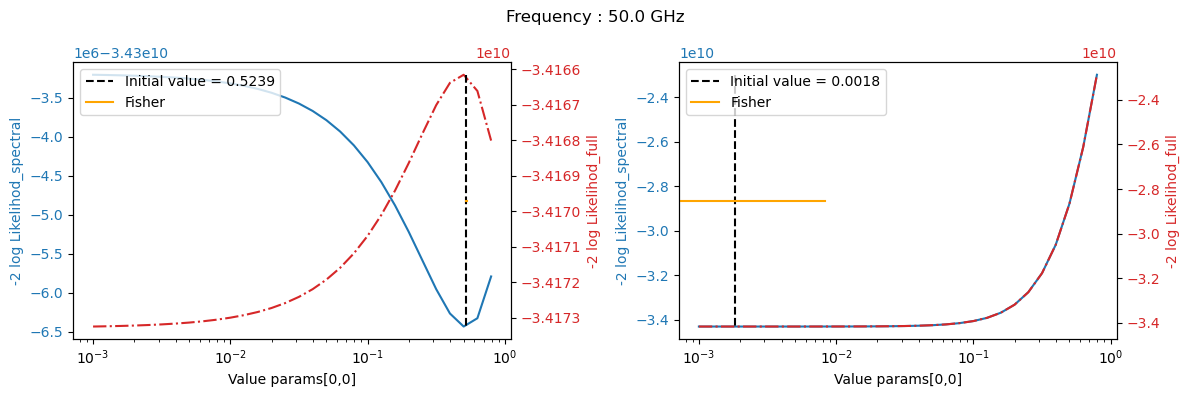

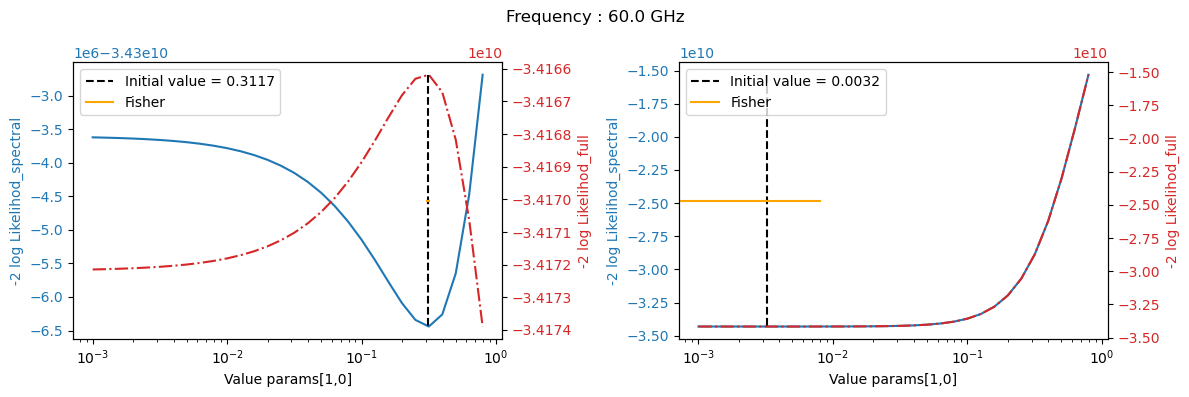

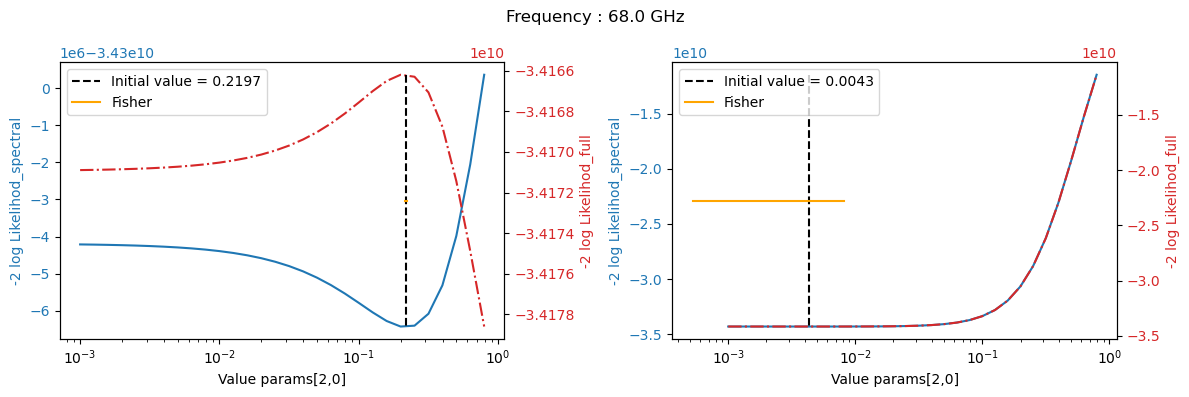

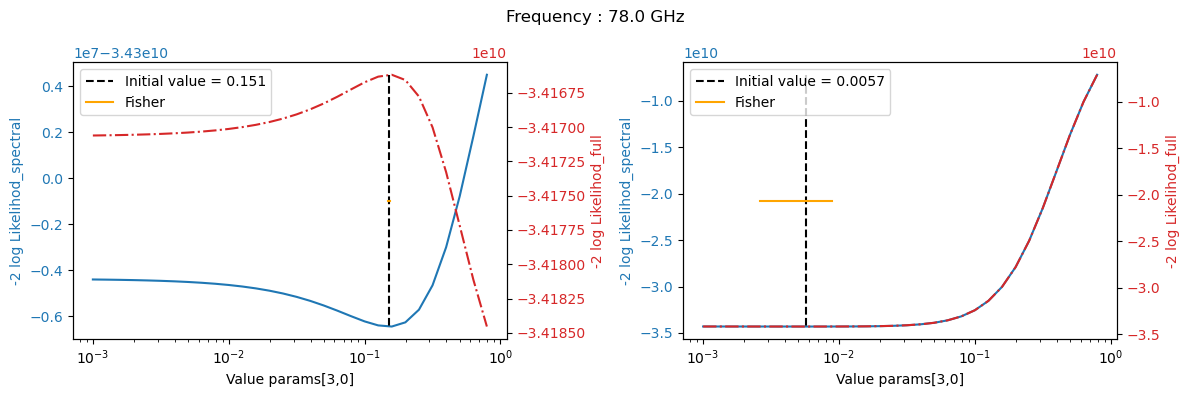

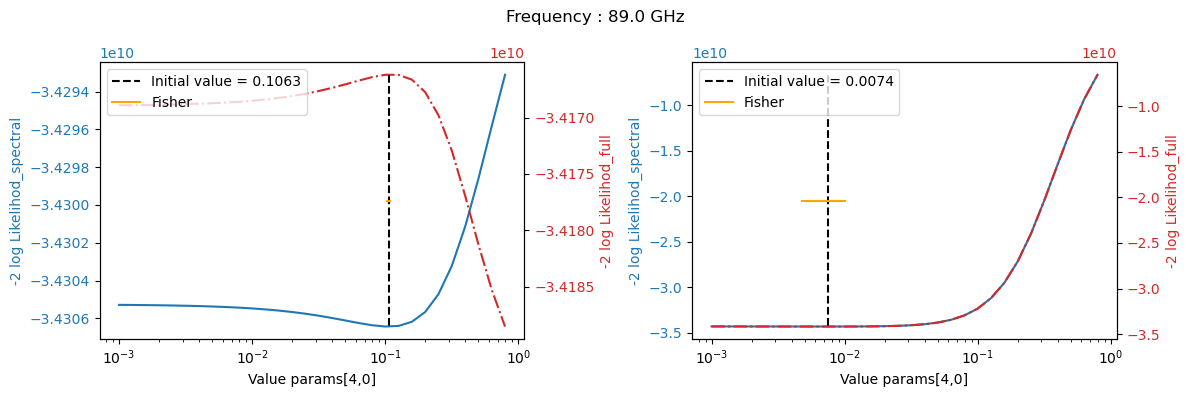

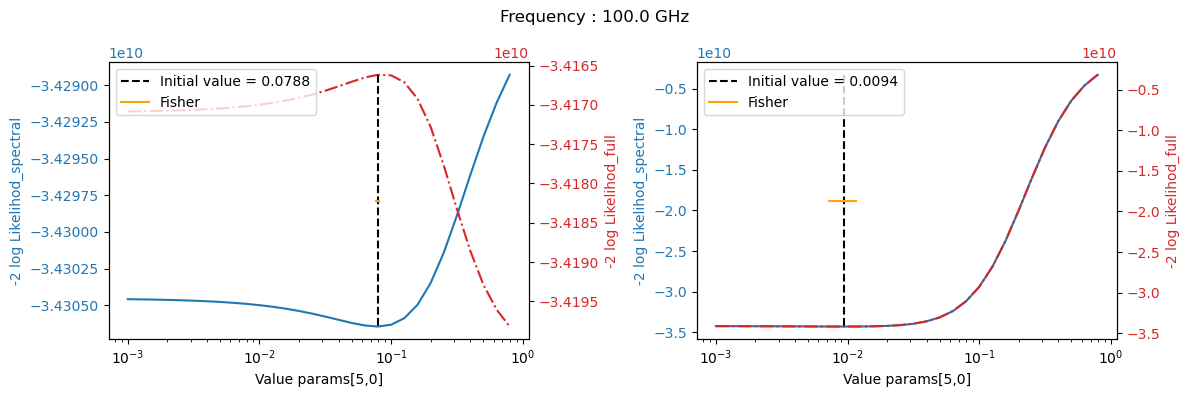

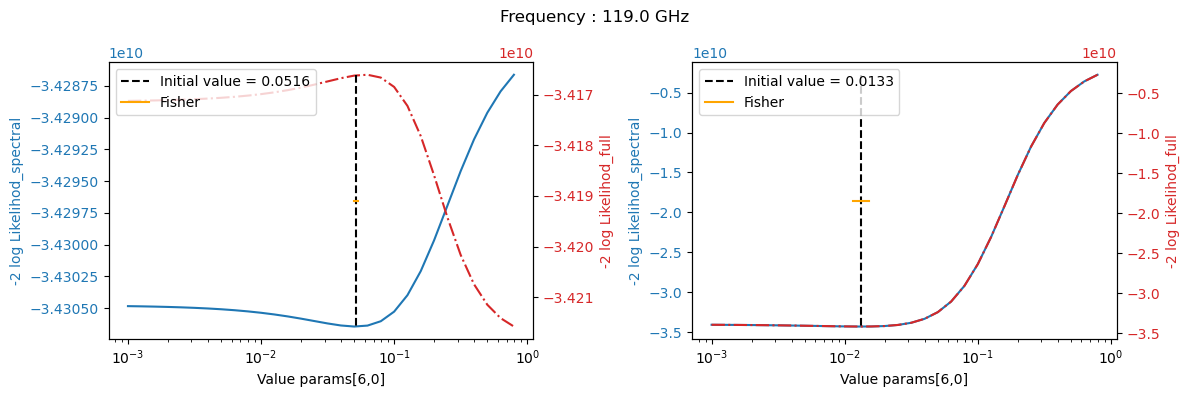

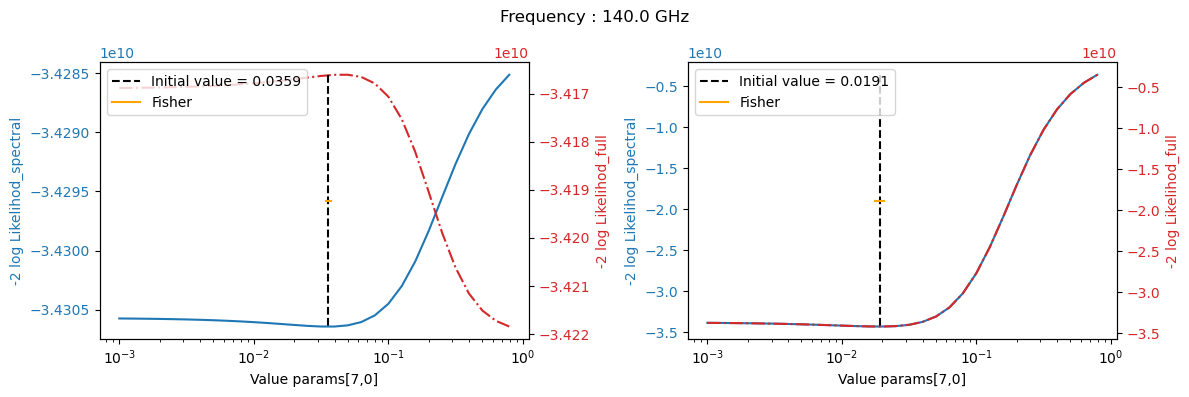

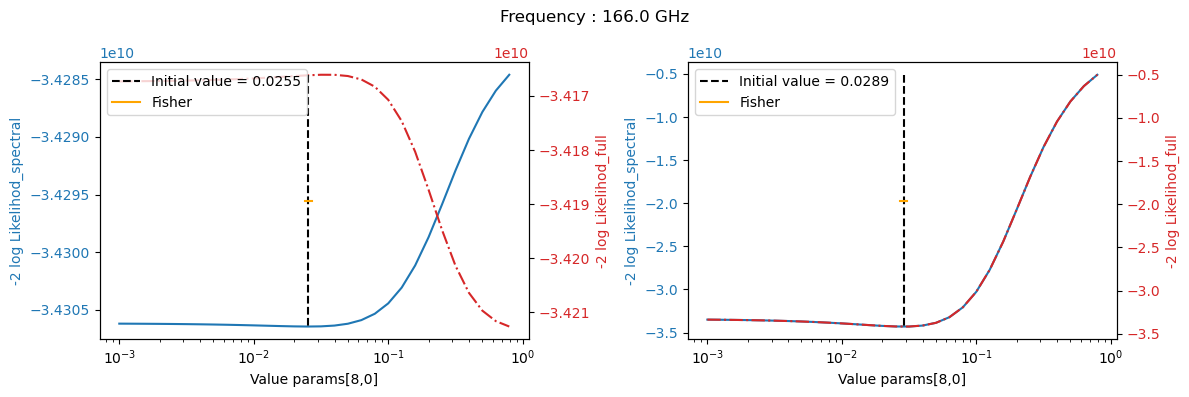

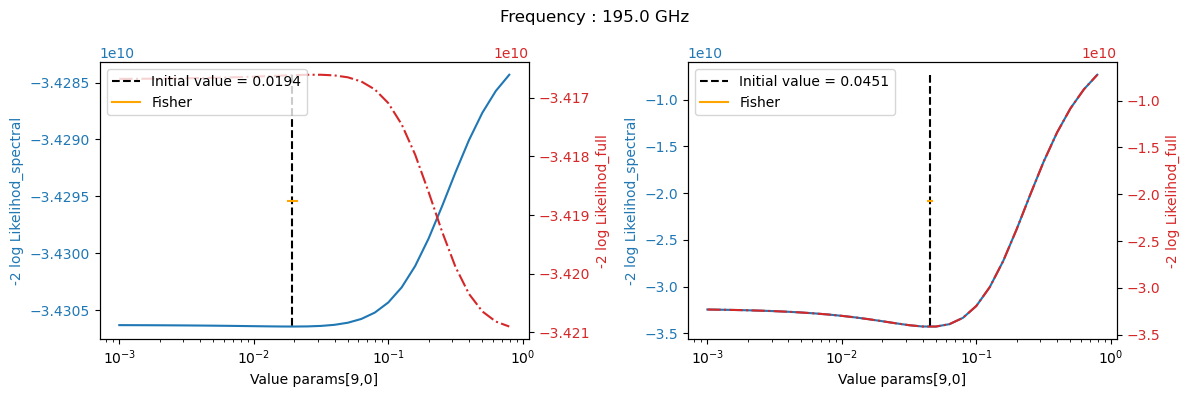

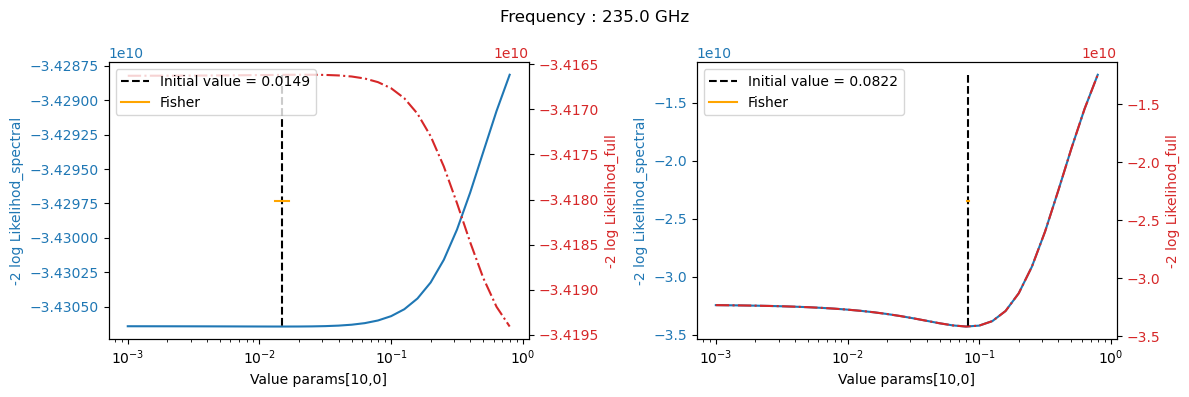

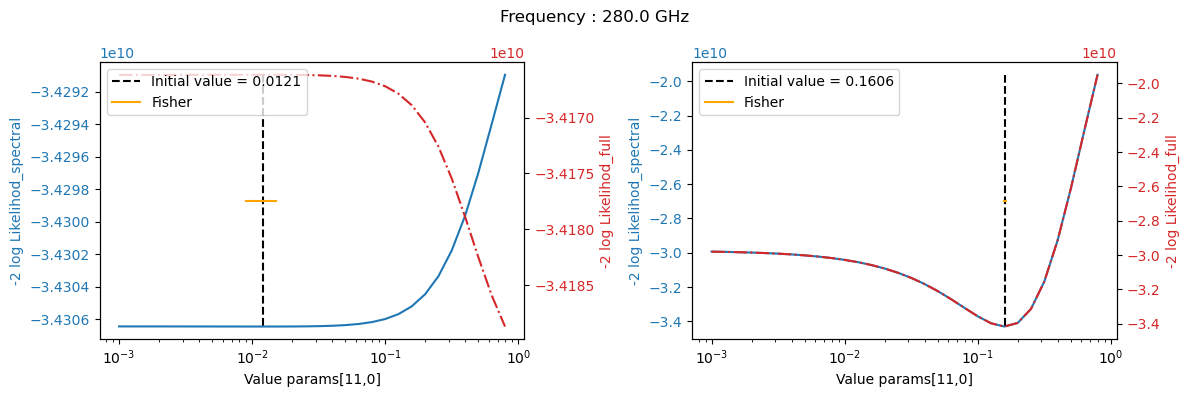

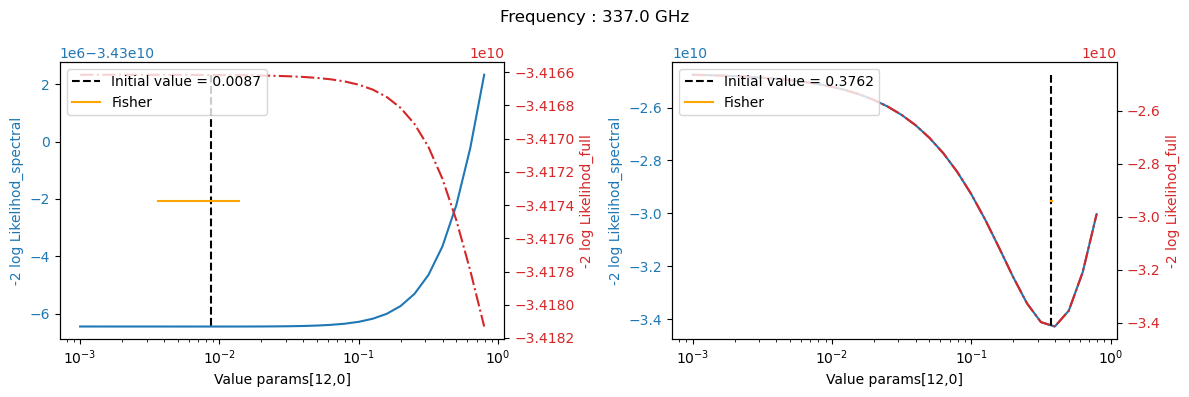

In [77]:
log_proba_griding_synch_broad = np.array(log_proba_samples_synch_list_broad)#-regularization_constant
log_proba_griding_dust_broad = np.array(log_proba_samples_dust_list_broad)#-regularization_constant

log_proba_griding_synch_full_broad = np.array(log_proba_samples_synch_full_proba_broad)#-regularization_constant
log_proba_griding_dust_full_broad = np.array(log_proba_samples_dust_full_proba_broad)#-regularization_constant

nb_Fisher = 5

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    # plt.figure(figsize=(15,4))
    
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    # fig, ax_array = plt.subplot(121)
    fig, ax_array = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    plt.suptitle('Frequency : {} GHz'.format(frequency_Bf[freq_coord+1]))
    # min_value = (-2*log_proba_griding_synch[freq_coord,:]).min()

    # plt.plot(griding_logspace_broad[0,freq_coord], -2*log_proba_griding_synch_broad[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_broad[0,freq_coord], -2*log_proba_griding_synch_full_broad[freq_coord,:], '-.', label='Full -2log-likelihood')
    ax1_1 = ax_array[0]
    ax1_1.set_xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    # ax1_1.set_xscale('symlog')
    ax1_1.set_xscale('log')
    ax1_1.plot(griding_logspace_broad, -2*log_proba_griding_synch_broad[freq_coord,:], color='tab:blue', label='Spectral -2log-likelihood')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')
    

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_full', color='tab:red')  # we already handled the x-label with ax1
    # ax1_2.plot(griding_logspace_broad[0,freq_coord], -2*log_proba_griding_synch_full_broad[freq_coord,:], '-.', color='tab:red', label='Full -2log-likelihood')
    ax1_2.plot(griding_logspace_broad, -2*log_proba_griding_synch_full_broad[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    # min_value = max(-2*log_proba_griding_synch_broad[freq_coord,:].min(),-2*log_proba_griding_synch_full_broad[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_synch_broad[freq_coord,:].max(),-2*log_proba_griding_synch_full_broad[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_broad.min(),-2*log_proba_griding_synch_full_broad.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_synch[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    min_value = -2*log_proba_griding_synch_full_broad[freq_coord,:].min()
    max_value = -2*log_proba_griding_synch_full_broad[freq_coord,:].max()
    # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_broad.min(),-2*log_proba_griding_synch_full_broad.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    gap = max_value - min_value
    ax1_2.plot(np.array([-5,5])*minimum_std_Fisher_diag[freq_coord]+initial_value, [min_value + gap/2,min_value + gap/2], color='orange', label='Fisher')
    # ax1_2.set_ylim(ymin=min_value*.99, ymax=max_value*1.01)

    # sigma_B_f = nb_Fisher*np.diag(minimum_std_Fisher)[freq_coord]
    # half_value = -np.median(log_proba_griding_synch[freq_coord,:])/2
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=r"$\sigma (B_{f})$"+f"~{percent_value}%")
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=f"{nb_Fisher}"+r"$\sigma_{Fisher}$")

    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with synch')
    plt.legend(loc='upper left')

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    
    
    # plt.subplot(122)
    # plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_broad[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_broad[1,freq_coord], -2*log_proba_griding_dust_full_broad[freq_coord,:], '-.', label='Full -2 log-likelihood')

    ax1_1 = ax_array[1]
    ax1_1.set_xlabel('Value params[{},{}] dust'.format(freq_coord, cpt_coord+1))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    # ax1_1.set_xscale('symlog')
    ax1_1.set_xscale('log')
    ax1_1.plot(griding_logspace_broad, -2*log_proba_griding_dust_broad[freq_coord,:], color='tab:blue')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_full', color='tab:red')  # we already handled the x-label with ax1
    ax1_2.plot(griding_logspace_broad, -2*log_proba_griding_dust_full_broad[freq_coord,:], '-.', color='tab:red')
    # ax1_2.plot(griding_logspace_broad, -2*(log_proba_griding_dust_broad[freq_coord,:]+log_proba_griding_dust_perturbation_broad[freq_coord,:]), '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    # min_value = max(-2*log_proba_griding_dust_broad[freq_coord,:].min(),-2*log_proba_griding_dust_full_broad[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_dust_broad[freq_coord,:].max(),-2*log_proba_griding_dust_full_broad[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full.min(),-2*log_proba_griding_dust_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full_broad.min(),-2*log_proba_griding_dust_full_broad.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord+1], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))

    min_value = -2*log_proba_griding_dust_full_broad[freq_coord,:].min()
    max_value = -2*log_proba_griding_dust_full_broad[freq_coord,:].max()
    gap = max_value - min_value
    ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    ax1_2.plot(np.array([-5,5])*minimum_std_Fisher_diag[freq_coord]+initial_value, [min_value + gap/2,min_value + gap/2], color='orange', label='Fisher')
    # ax1_2.set_ylim(ymin=min_value*.99, ymax=max_value*1.01)
    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord+1))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with dust')
    # # plt.xlim(xmin=.5*initial_value, xmax=1.5*initial_value)
    plt.legend(loc='upper left')
    plt.show()


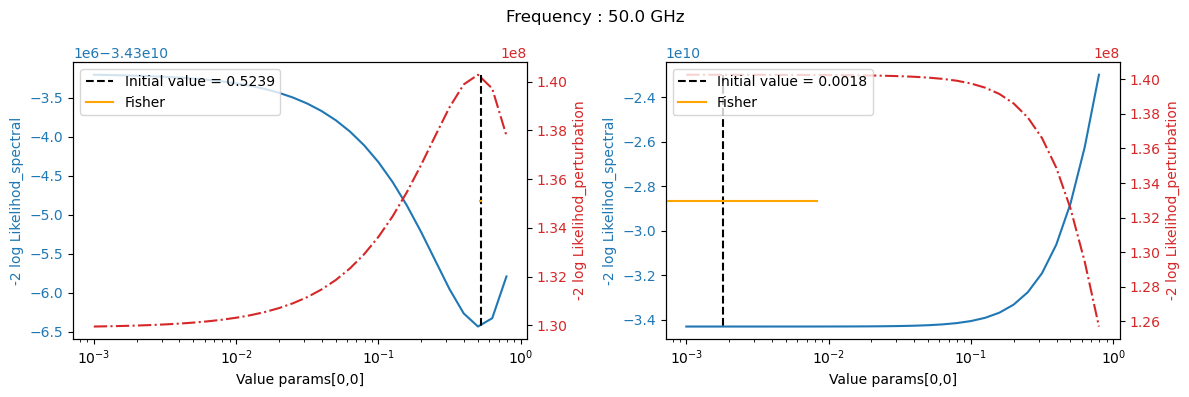

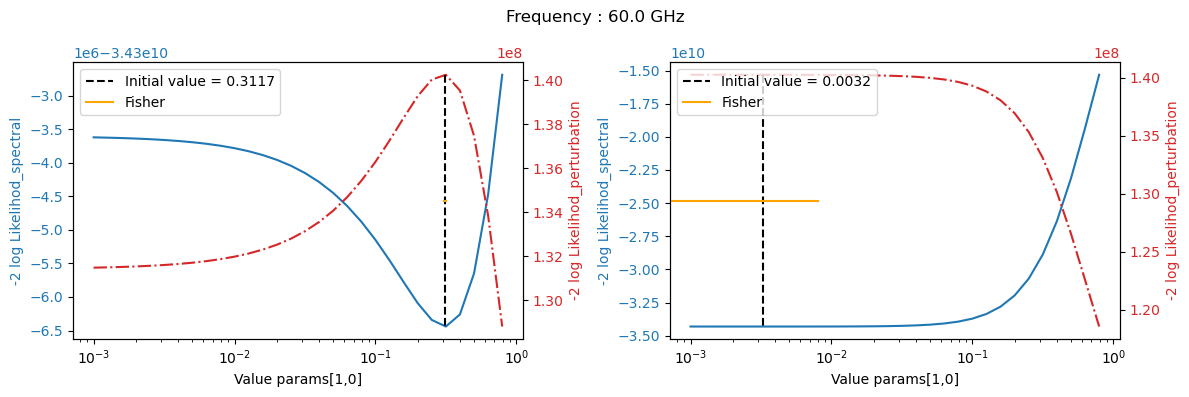

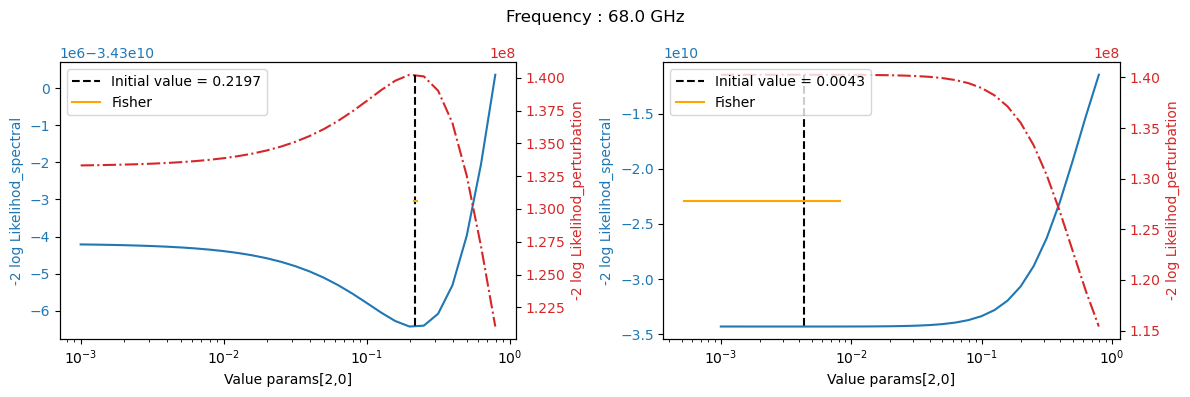

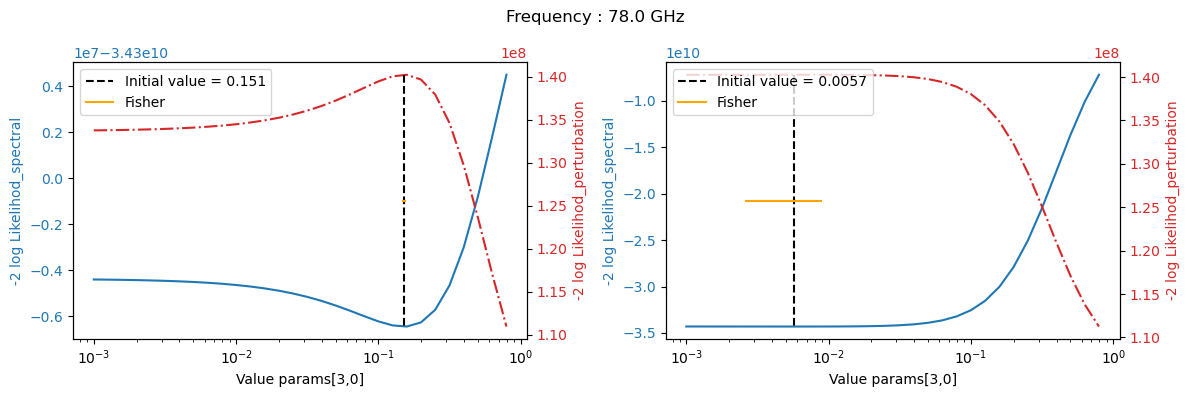

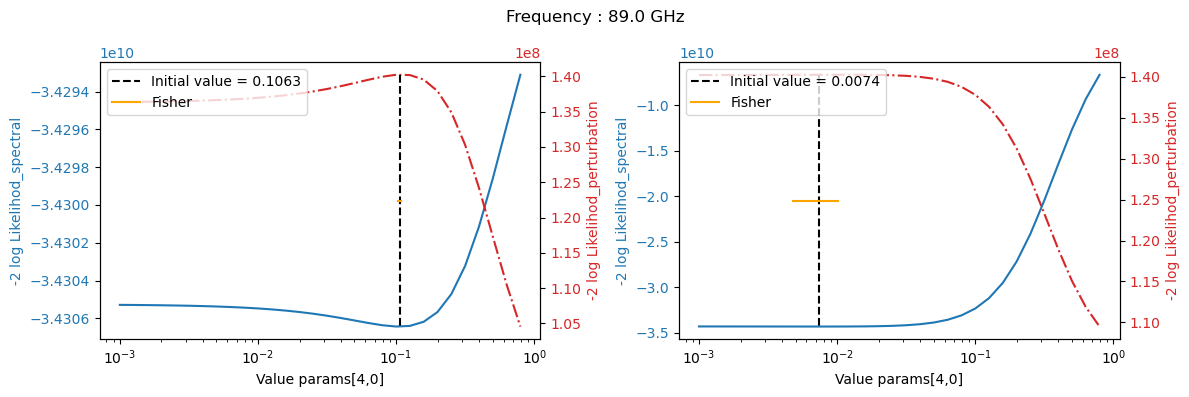

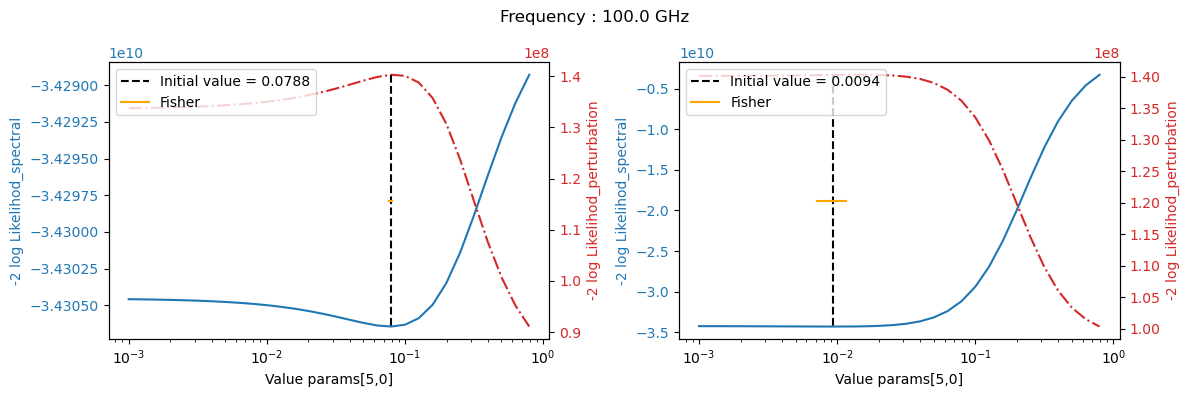

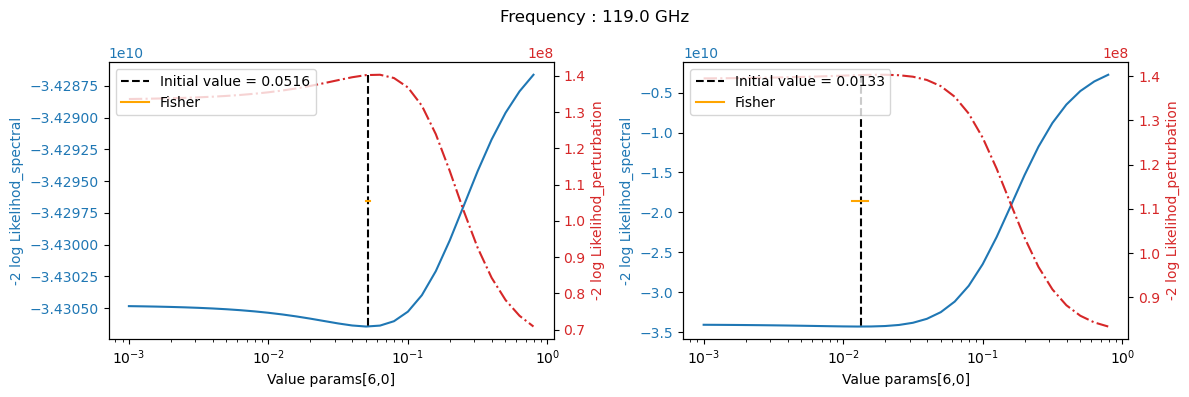

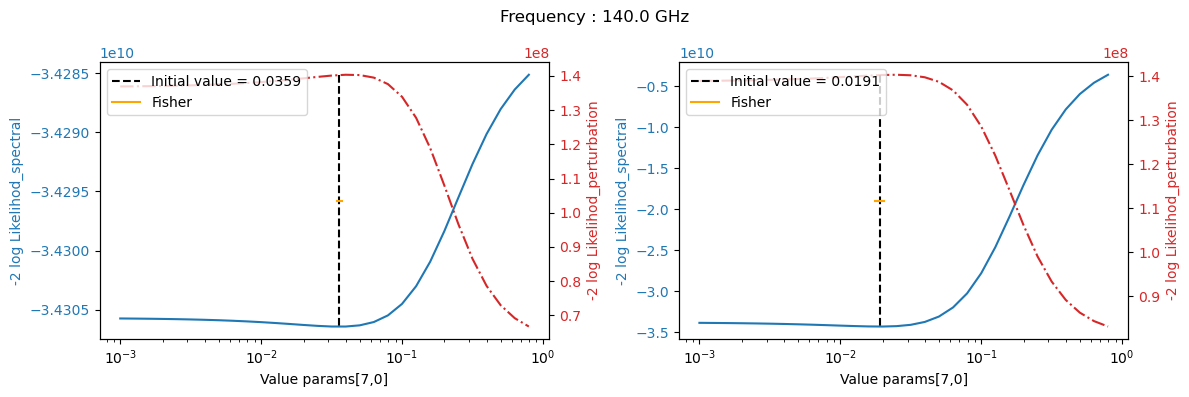

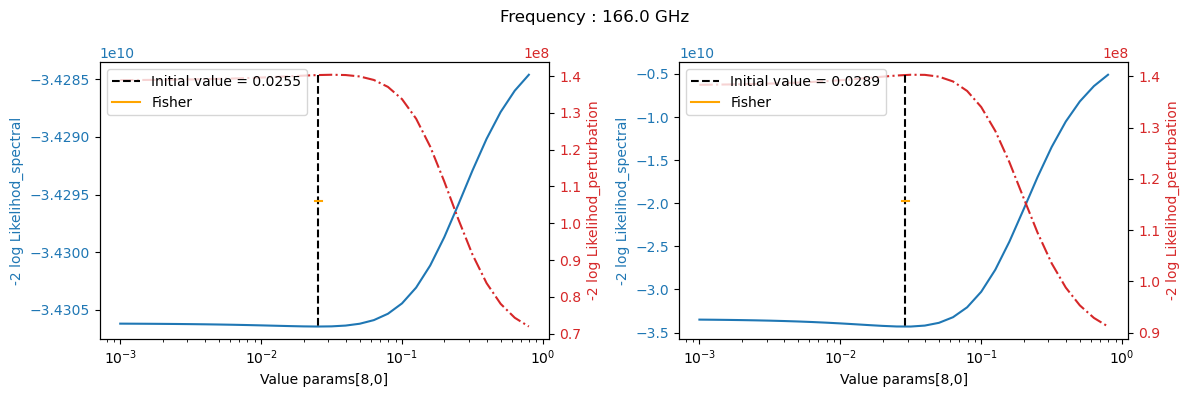

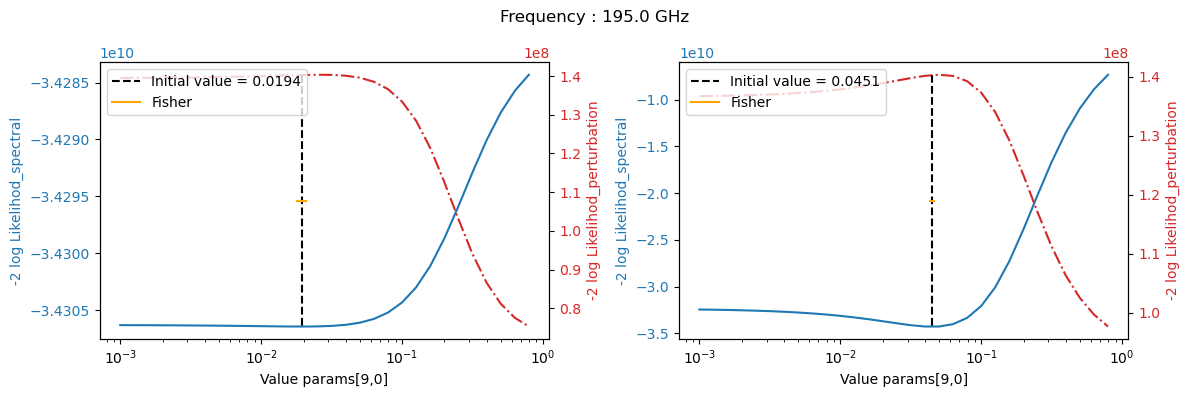

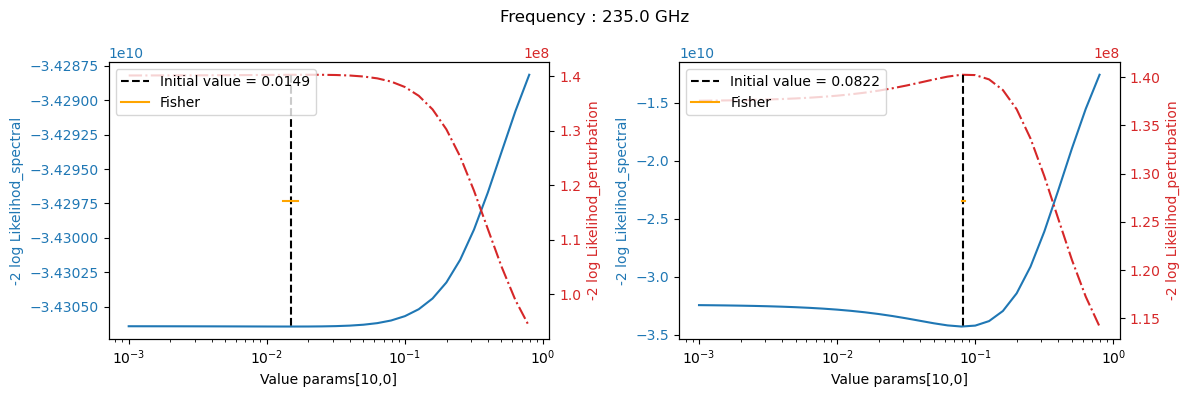

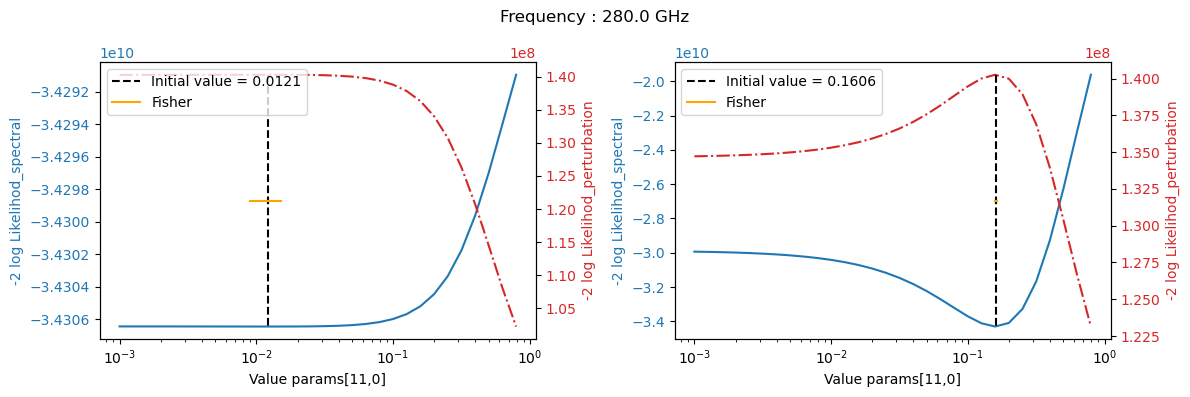

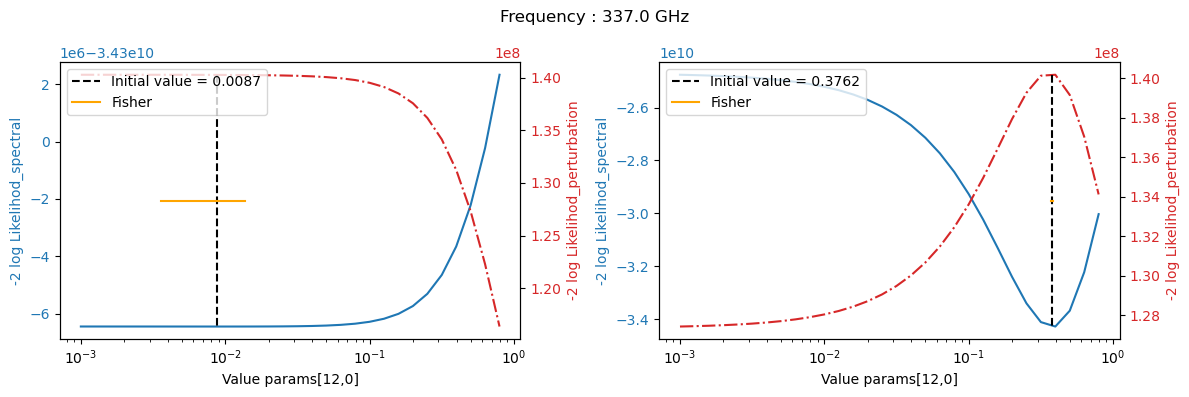

In [78]:
log_proba_griding_synch_broad = np.array(log_proba_samples_synch_list_broad)#-regularization_constant
log_proba_griding_dust_broad = np.array(log_proba_samples_dust_list_broad)#-regularization_constant

log_proba_griding_synch_perturbation_broad = np.array(log_proba_samples_synch_perturbation_proba_broad)#-regularization_constant
log_proba_griding_dust_perturbation_broad = np.array(log_proba_samples_dust_perturbation_proba_broad)#-regularization_constant

nb_Fisher = 5

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    # plt.figure(figsize=(15,4))
    
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    # fig, ax_array = plt.subplot(121)
    fig, ax_array = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    plt.suptitle('Frequency : {} GHz'.format(frequency_Bf[freq_coord+1]))
    # min_value = (-2*log_proba_griding_synch[freq_coord,:]).min()

    # plt.plot(griding_logspace_broad[0,freq_coord], -2*log_proba_griding_synch_broad[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_broad[0,freq_coord], -2*log_proba_griding_synch_full_broad[freq_coord,:], '-.', label='Full -2log-likelihood')
    ax1_1 = ax_array[0]
    ax1_1.set_xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    # ax1_1.set_xscale('symlog')
    ax1_1.set_xscale('log')
    ax1_1.plot(griding_logspace_broad, -2*log_proba_griding_synch_broad[freq_coord,:], color='tab:blue', label='Spectral -2log-likelihood')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')
    

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_perturbation', color='tab:red')  # we already handled the x-label with ax1
    # ax1_2.plot(griding_logspace_broad[0,freq_coord], -2*log_proba_griding_synch_full_broad[freq_coord,:], '-.', color='tab:red', label='Full -2log-likelihood')
    ax1_2.plot(griding_logspace_broad, -2*log_proba_griding_synch_perturbation_broad[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    # min_value = max(-2*log_proba_griding_synch_broad[freq_coord,:].min(),-2*log_proba_griding_synch_full_broad[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_synch_broad[freq_coord,:].max(),-2*log_proba_griding_synch_full_broad[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_broad.min(),-2*log_proba_griding_synch_full_broad.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_synch[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    min_value = -2*log_proba_griding_synch_perturbation_broad[freq_coord,:].min()
    max_value = -2*log_proba_griding_synch_perturbation_broad[freq_coord,:].max()
    # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_broad.min(),-2*log_proba_griding_synch_full_broad.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    gap = max_value - min_value
    ax1_2.plot(np.array([-5,5])*minimum_std_Fisher_diag[freq_coord]+initial_value, [min_value + gap/2,min_value + gap/2], color='orange', label='Fisher')
    # ax1_2.set_ylim(ymin=min_value*.99, ymax=max_value*1.01)

    # sigma_B_f = nb_Fisher*np.diag(minimum_std_Fisher)[freq_coord]
    # half_value = -np.median(log_proba_griding_synch[freq_coord,:])/2
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=r"$\sigma (B_{f})$"+f"~{percent_value}%")
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=f"{nb_Fisher}"+r"$\sigma_{Fisher}$")

    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with synch')
    plt.legend(loc='upper left')

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    
    
    # plt.subplot(122)
    # plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_broad[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_broad[1,freq_coord], -2*log_proba_griding_dust_full_broad[freq_coord,:], '-.', label='Full -2 log-likelihood')

    ax1_1 = ax_array[1]
    ax1_1.set_xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    # ax1_1.set_xscale('symlog')
    ax1_1.set_xscale('log')
    ax1_1.plot(griding_logspace_broad, -2*log_proba_griding_dust_broad[freq_coord,:], color='tab:blue')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_perturbation', color='tab:red')  # we already handled the x-label with ax1
    ax1_2.plot(griding_logspace_broad, -2*log_proba_griding_dust_perturbation_broad[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    # min_value = max(-2*log_proba_griding_dust_broad[freq_coord,:].min(),-2*log_proba_griding_dust_full_broad[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_dust_broad[freq_coord,:].max(),-2*log_proba_griding_dust_full_broad[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full.min(),-2*log_proba_griding_dust_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full_broad.min(),-2*log_proba_griding_dust_full_broad.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord+1], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))

    min_value = -2*log_proba_griding_dust_perturbation_broad[freq_coord,:].min()
    max_value = -2*log_proba_griding_dust_perturbation_broad[freq_coord,:].max()
    gap = max_value - min_value
    ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    ax1_2.plot(np.array([-5,5])*minimum_std_Fisher_diag[freq_coord]+initial_value, [min_value + gap/2,min_value + gap/2], color='orange', label='Fisher')
    # ax1_2.set_ylim(ymin=min_value*.5, ymax=max_value*1.5)
    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord+1))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with dust')
    # # plt.xlim(xmin=.5*initial_value, xmax=1.5*initial_value)
    plt.legend(loc='upper left')
    plt.show()


In [79]:
# griding_logspace_fine = np.empty((2, number_frequencies-2, 50))
griding_logspace_fine = np.empty((2, number_frequencies-2, 50))

n_sigma = 10
step_size = 2*n_sigma/50

# log_proba_griding = []
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace]
log_proba_samples_synch_list_fine = np.empty((number_frequencies-2, griding_logspace_fine.shape[-1]))
log_proba_samples_dust_list_fine = np.empty((number_frequencies-2, griding_logspace_fine.shape[-1]))
for freq_coord in range(number_frequencies-2):
    initial_value = init_params[freq_coord, 0]
    griding_logspace_fine[0,freq_coord,...] = np.arange(-n_sigma,n_sigma,step_size)*minimum_std_Fisher_diag[freq_coord] + initial_value
    log_proba_samples_synch_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[0,freq_coord,...]])
    initial_value = init_params[freq_coord, 1]
    griding_logspace_fine[1,freq_coord,...] = np.arange(-n_sigma,n_sigma,step_size)*minimum_std_Fisher_diag[freq_coord + number_frequencies-2] + initial_value
    log_proba_samples_dust_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[1,freq_coord,...]])


log_proba_samples_synch_full_proba_fine = np.empty((number_frequencies-2, griding_logspace_fine.shape[-1]))
log_proba_samples_synch_perturbation_proba_fine = np.empty((number_frequencies-2, griding_logspace_fine.shape[-1]))
log_proba_samples_dust_full_proba_fine = np.empty((number_frequencies-2, griding_logspace_fine.shape[-1]))
log_proba_samples_dust_perturbation_proba_fine = np.empty((number_frequencies-2, griding_logspace_fine.shape[-1]))
for freq_coord in range(number_frequencies-2):
    print("Nb freq n°3 :", freq_coord, number_frequencies-2)
    log_proba_samples_synch_perturbation_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_perturbation_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[0,freq_coord,...]])
    print("Nb freq n°4 :", freq_coord, number_frequencies-2)
    log_proba_samples_dust_perturbation_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_perturbation_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[1,freq_coord,...]])
    print("Nb freq :", freq_coord, number_frequencies-2)
    # log_proba_samples_synch_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[0,freq_coord,...]])
    log_proba_samples_synch_full_proba_fine[freq_coord,...] = log_proba_samples_synch_perturbation_proba_fine[freq_coord,...] + log_proba_samples_synch_list_fine[freq_coord,...]
    print("Nb freq n°2 :", freq_coord, number_frequencies-2)
    # log_proba_samples_dust_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=modified_sample_eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[1,freq_coord,...]])
    log_proba_samples_dust_full_proba_fine[freq_coord,...] = log_proba_samples_dust_perturbation_proba_fine[freq_coord,...] + log_proba_samples_dust_list_fine[freq_coord,...]


Nb freq n°3 : 0 13
Nb freq n°4 : 0 13
Nb freq : 0 13
Nb freq n°2 : 0 13
Nb freq n°3 : 1 13
Nb freq n°4 : 1 13
Nb freq : 1 13
Nb freq n°2 : 1 13
Nb freq n°3 : 2 13
Nb freq n°4 : 2 13
Nb freq : 2 13
Nb freq n°2 : 2 13
Nb freq n°3 : 3 13
Nb freq n°4 : 3 13
Nb freq : 3 13
Nb freq n°2 : 3 13
Nb freq n°3 : 4 13
Nb freq n°4 : 4 13
Nb freq : 4 13
Nb freq n°2 : 4 13
Nb freq n°3 : 5 13
Nb freq n°4 : 5 13
Nb freq : 5 13
Nb freq n°2 : 5 13
Nb freq n°3 : 6 13
Nb freq n°4 : 6 13
Nb freq : 6 13
Nb freq n°2 : 6 13
Nb freq n°3 : 7 13
Nb freq n°4 : 7 13
Nb freq : 7 13
Nb freq n°2 : 7 13
Nb freq n°3 : 8 13
Nb freq n°4 : 8 13
Nb freq : 8 13
Nb freq n°2 : 8 13
Nb freq n°3 : 9 13
Nb freq n°4 : 9 13
Nb freq : 9 13
Nb freq n°2 : 9 13
Nb freq n°3 : 10 13
Nb freq n°4 : 10 13
Nb freq : 10 13
Nb freq n°2 : 10 13
Nb freq n°3 : 11 13
Nb freq n°4 : 11 13
Nb freq : 11 13
Nb freq n°2 : 11 13
Nb freq n°3 : 12 13
Nb freq n°4 : 12 13
Nb freq : 12 13
Nb freq n°2 : 12 13


In [80]:
np.diag(minimum_std_Fisher), minimum_std_Fisher_diag

(array([1.29324268e-03, 9.62148633e-04, 7.62460177e-04, 6.23283957e-04,
        5.36182447e-04, 4.29689251e-04, 3.62604834e-04, 2.96497747e-04,
        3.19329897e-04, 2.94524649e-04, 3.75601363e-04, 6.23341646e-04,
        1.02018086e-03, 4.95614237e-05, 3.68731309e-05, 2.92207210e-05,
        2.38873861e-05, 2.05496919e-05, 1.64688905e-05, 1.38983823e-05,
        1.13653364e-05, 1.22402409e-05, 1.12896537e-05, 1.43962019e-05,
        2.38896043e-05, 3.90970393e-05, 9.22799496e-05]),
 array([1.29324268e-03, 9.62148633e-04, 7.62460177e-04, 6.23283957e-04,
        5.36182447e-04, 4.29689251e-04, 3.62604834e-04, 2.96497747e-04,
        3.19329897e-04, 2.94524649e-04, 3.75601363e-04, 6.23341646e-04,
        1.02018086e-03, 4.95614237e-05, 3.68731309e-05, 2.92207210e-05,
        2.38873861e-05, 2.05496919e-05, 1.64688905e-05, 1.38983823e-05,
        1.13653364e-05, 1.22402409e-05, 1.12896537e-05, 1.43962019e-05,
        2.38896043e-05, 3.90970393e-05, 9.22799496e-05]))

In [81]:
# %%time

# freq_coord = 0
# initial_value = init_params[freq_coord, cpt_coord+1]
# griding_logspace_fine[1,freq_coord,...] = np.arange(-5,5,.2)*minimum_std_Fisher_diag[freq_coord + number_frequencies-2] + initial_value
# # griding_logspace_fine[1,freq_coord,...] = np.linspace(-5000,5,num=50)*np.diag(minimum_std_Fisher)[freq_coord + number_frequencies-2] + initial_value

# # log_proba_samples_dust_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[1,freq_coord,...]])
# # log_proba_samples_dust_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[1,freq_coord,...]])
# log_proba_samples_dust_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, sample_eta_maps=eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[1,freq_coord,...]])
# log_proba_samples_dust_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, sample_eta_maps=eta_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True) for value_param in griding_logspace_fine[1,freq_coord,...]])

In [82]:
init_params

array([[0.52387813, 0.00182426],
       [0.3117258 , 0.00324908],
       [0.21971687, 0.00433627],
       [0.15096497, 0.0057459 ],
       [0.10631274, 0.0074421 ],
       [0.07881344, 0.00935487],
       [0.05159725, 0.0133358 ],
       [0.03585547, 0.01906532],
       [0.02552178, 0.02888587],
       [0.0193825 , 0.04508262],
       [0.01493871, 0.08217483],
       [0.01211497, 0.16061503],
       [0.00871575, 0.37616284]])

In [83]:
minimum_std_Fisher_diag

array([1.29324268e-03, 9.62148633e-04, 7.62460177e-04, 6.23283957e-04,
       5.36182447e-04, 4.29689251e-04, 3.62604834e-04, 2.96497747e-04,
       3.19329897e-04, 2.94524649e-04, 3.75601363e-04, 6.23341646e-04,
       1.02018086e-03, 4.95614237e-05, 3.68731309e-05, 2.92207210e-05,
       2.38873861e-05, 2.05496919e-05, 1.64688905e-05, 1.38983823e-05,
       1.13653364e-05, 1.22402409e-05, 1.12896537e-05, 1.43962019e-05,
       2.38896043e-05, 3.90970393e-05, 9.22799496e-05])

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/375702861.py:35: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax1_2 = ax1_1.twinx()
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/375702861.py:43: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.tight_layout()
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/375702861.py:92: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax1_2 = ax1_1.twinx()
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/375702861.py:96: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.tight_layout()
/Users/mag/miniconda3/envs

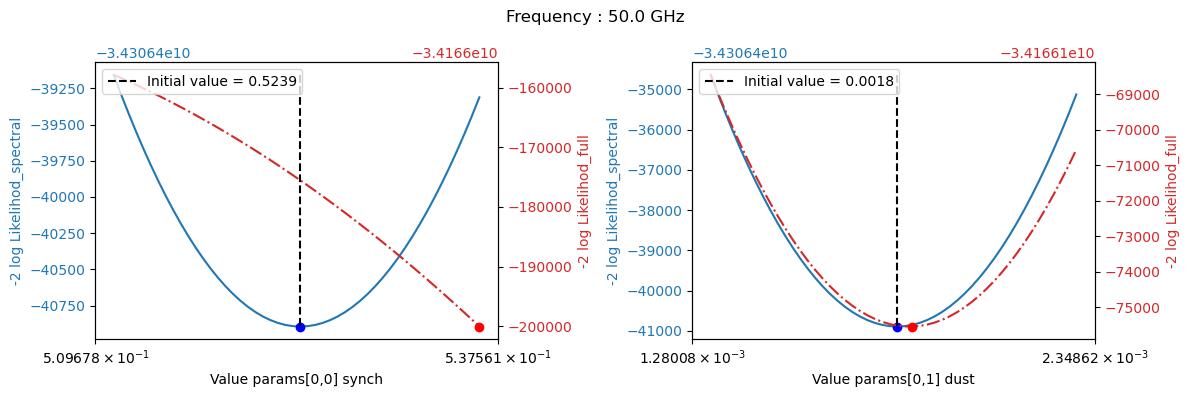

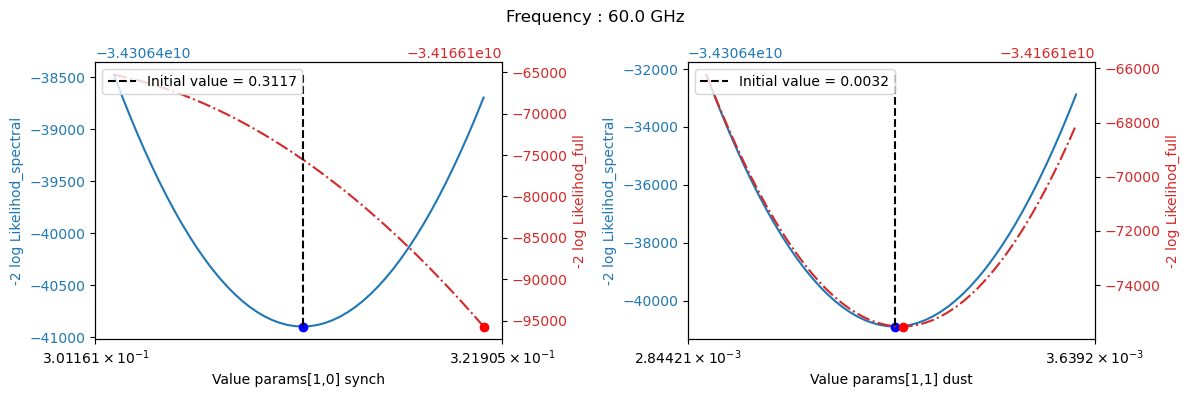

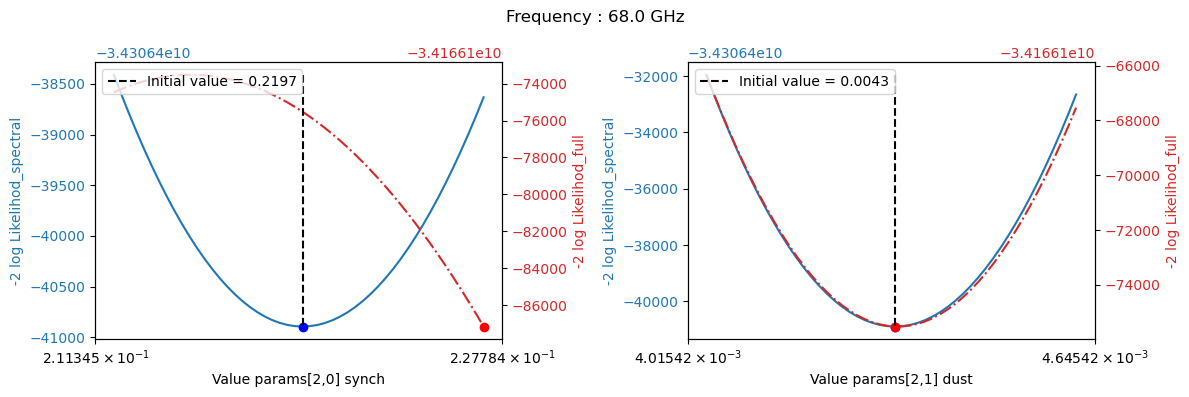

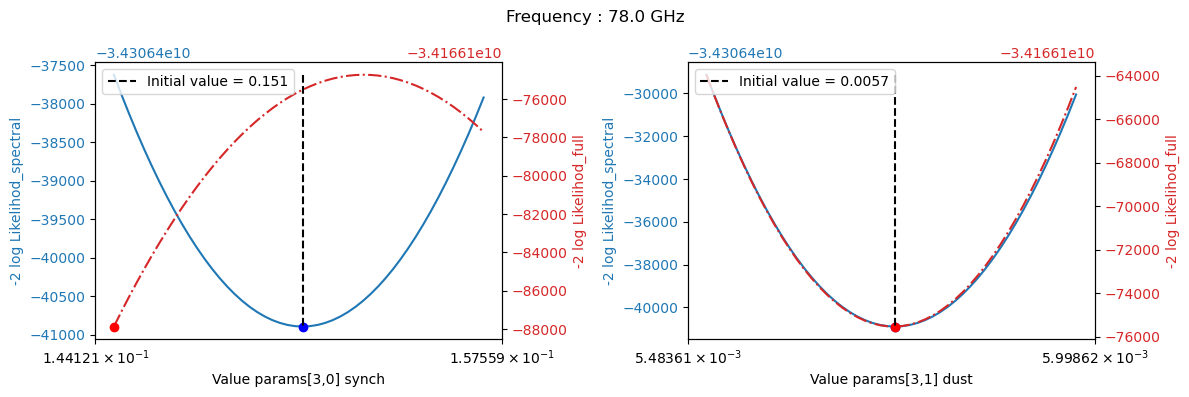

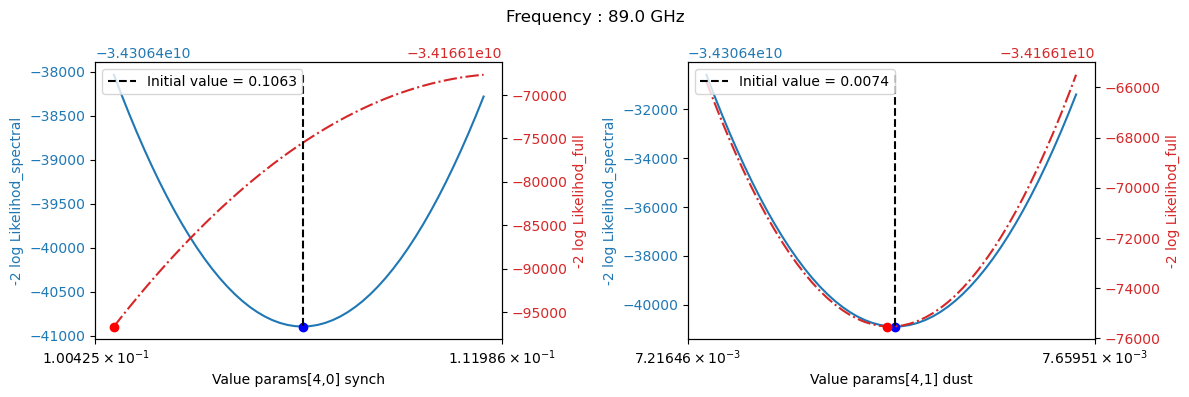

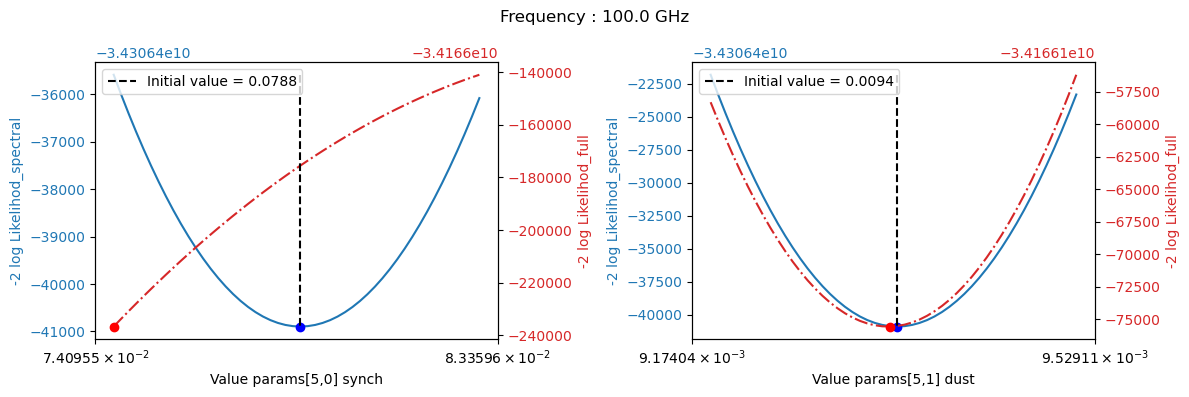

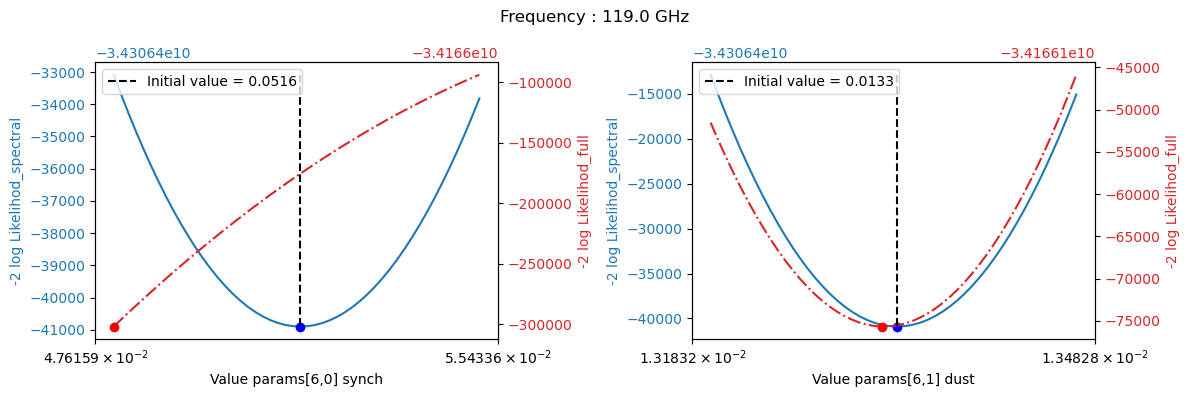

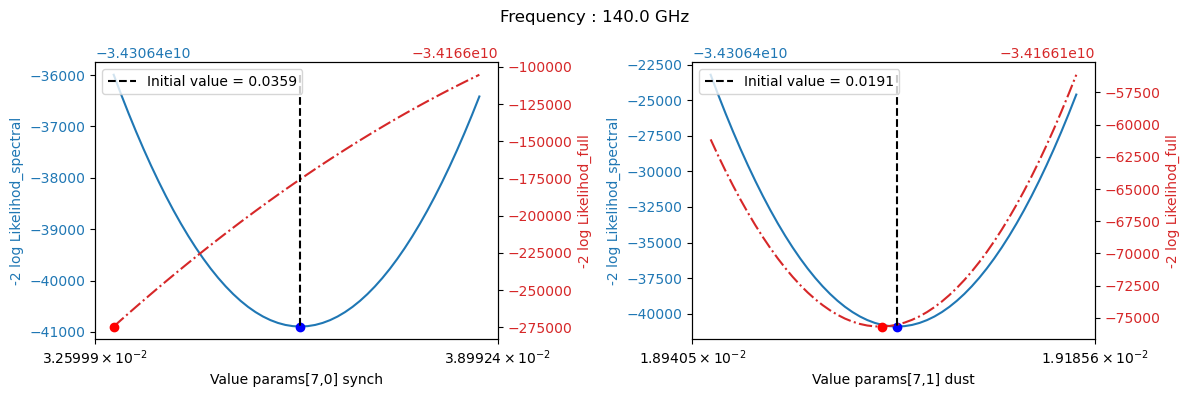

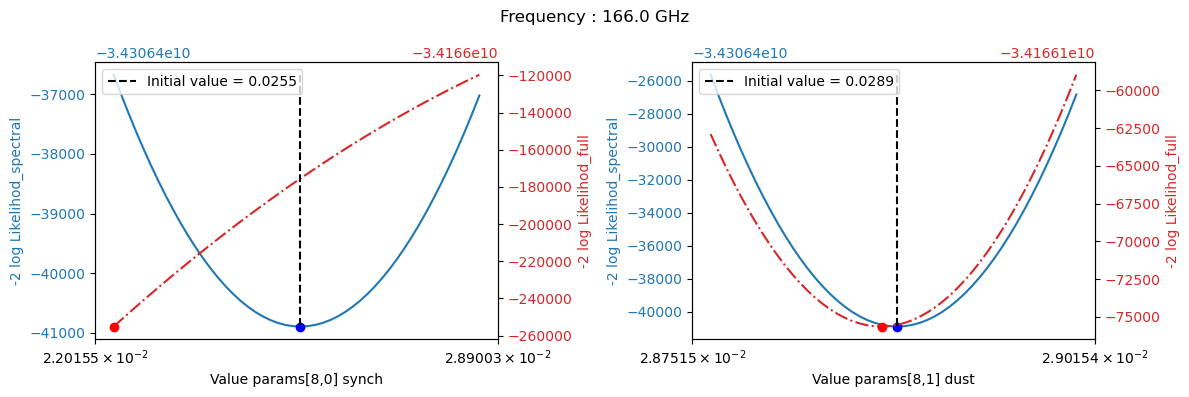

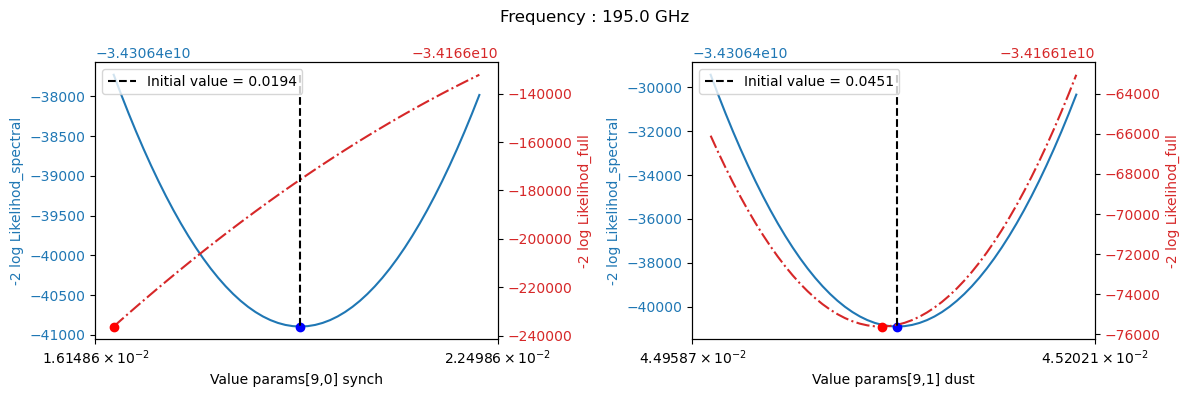

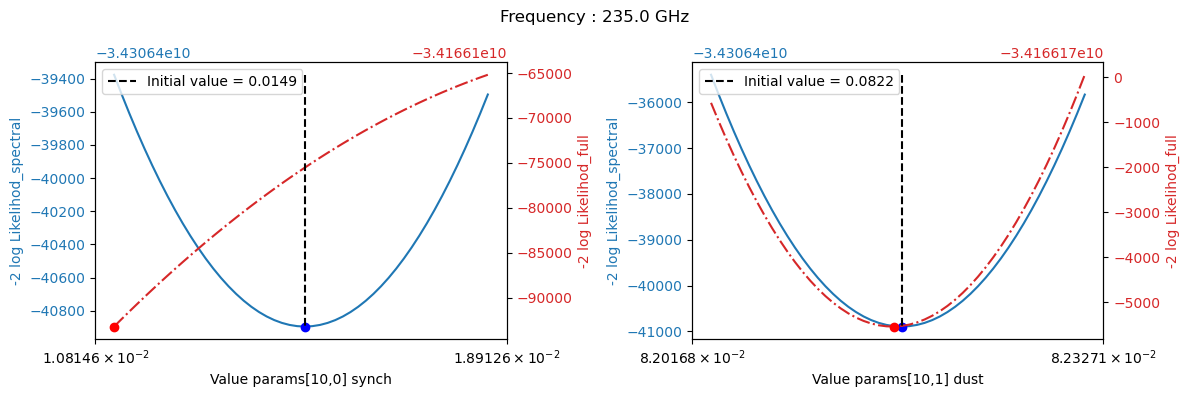

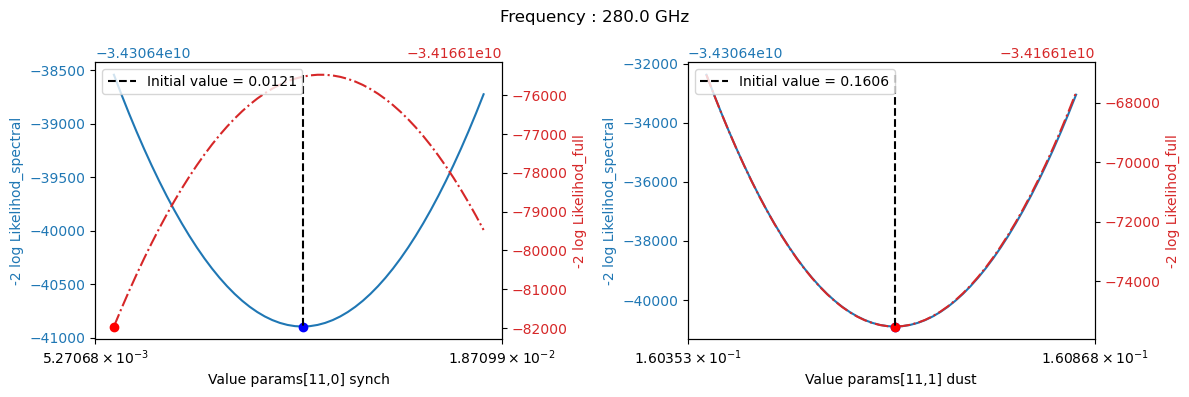

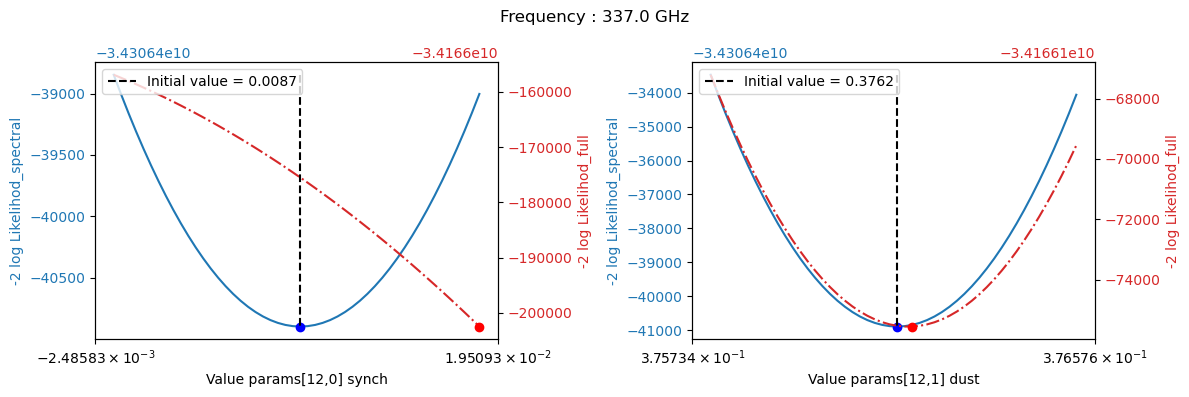

In [84]:
log_proba_griding_synch_fine = np.array(log_proba_samples_synch_list_fine)#-regularization_constant
log_proba_griding_dust_fine = np.array(log_proba_samples_dust_list_fine)#-regularization_constant

log_proba_griding_synch_full_fine = np.array(log_proba_samples_synch_full_proba_fine)#-regularization_constant
log_proba_griding_dust_full_fine = np.array(log_proba_samples_dust_full_proba_fine)#-regularization_constant

nb_Fisher = 5

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    # plt.figure(figsize=(15,4))
    
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    # fig, ax_array = plt.subplot(121)
    fig, ax_array = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    plt.suptitle('Frequency : {} GHz'.format(frequency_Bf[freq_coord+1]))
    # min_value = (-2*log_proba_griding_synch[freq_coord,:]).min()

    # plt.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_fine[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_full_fine[freq_coord,:], '-.', label='Full -2log-likelihood')
    ax1_1 = ax_array[0]
    ax1_1.set_xlabel('Value params[{},{}] synch'.format(freq_coord, cpt_coord))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    ax1_1.set_xscale('symlog')
    ax1_1.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_fine[freq_coord,:], color='tab:blue', label='Spectral -2log-likelihood')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')
    true_min_log_value = np.min(-2*log_proba_griding_synch_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_synch_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_1.plot([griding_logspace_fine[0,freq_coord,value_Bf_min]],[true_min_log_value],'o', color='blue')
    

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_full', color='tab:red')  # we already handled the x-label with ax1
    # ax1_2.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_full_fine[freq_coord,:], '-.', color='tab:red', label='Full -2log-likelihood')
    ax1_2.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_full_fine[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    true_min_log_value = np.min(-2*log_proba_griding_synch_full_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_synch_full_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_2.plot(griding_logspace_fine[0,freq_coord,value_Bf_min],[true_min_log_value],'o', color='red')
    fig.tight_layout()
    
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    # min_value = max(-2*log_proba_griding_synch_fine[freq_coord,:].min(),-2*log_proba_griding_synch_full_fine[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_synch_fine[freq_coord,:].max(),-2*log_proba_griding_synch_full_fine[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_fine.min(),-2*log_proba_griding_synch_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_synch[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    min_value = -2*log_proba_griding_synch_full_fine[freq_coord,:].min()
    max_value = -2*log_proba_griding_synch_full_fine[freq_coord,:].max()
    # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_fine.min(),-2*log_proba_griding_synch_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    


    # sigma_B_f = nb_Fisher*np.diag(minimum_std_Fisher)[freq_coord]
    # half_value = -np.median(log_proba_griding_synch[freq_coord,:])/2
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=r"$\sigma (B_{f})$"+f"~{percent_value}%")
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=f"{nb_Fisher}"+r"$\sigma_{Fisher}$")

    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with synch')
    plt.legend(loc='upper left')

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    
    
    # plt.subplot(122)
    # plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_fine[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_full_fine[freq_coord,:], '-.', label='Full -2 log-likelihood')

    ax1_1 = ax_array[1]
    ax1_1.set_xlabel('Value params[{},{}] dust'.format(freq_coord, cpt_coord+1))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    ax1_1.set_xscale('symlog')
    ax1_1.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_fine[freq_coord,:], color='tab:blue')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')
    true_min_log_value = np.min(-2*log_proba_griding_dust_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_dust_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_1.plot([griding_logspace_fine[1,freq_coord,value_Bf_min]],[true_min_log_value],'o', color='blue')

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_full', color='tab:red')  # we already handled the x-label with ax1
    ax1_2.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_full_fine[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    true_min_log_value = np.min(-2*log_proba_griding_dust_full_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_dust_full_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_2.plot(griding_logspace_fine[1,freq_coord,value_Bf_min],[true_min_log_value],'o', color='red')
    # min_value = max(-2*log_proba_griding_dust_fine[freq_coord,:].min(),-2*log_proba_griding_dust_full_fine[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_dust_fine[freq_coord,:].max(),-2*log_proba_griding_dust_full_fine[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full.min(),-2*log_proba_griding_dust_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full_fine.min(),-2*log_proba_griding_dust_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord+1], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))

    min_value = -2*log_proba_griding_dust_full_fine[freq_coord,:].min()
    max_value = -2*log_proba_griding_dust_full_fine[freq_coord,:].max()
    ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    
    
    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord+1))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with dust')
    # # plt.xlim(xmin=.5*initial_value, xmax=1.5*initial_value)
    plt.legend(loc='upper left')
    plt.show()


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/2160181133.py:34: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax1_2 = ax1_1.twinx()
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/2160181133.py:39: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.tight_layout()
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/2160181133.py:91: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax1_2 = ax1_1.twinx()
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_6297/2160181133.py:95: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.tight_layout()


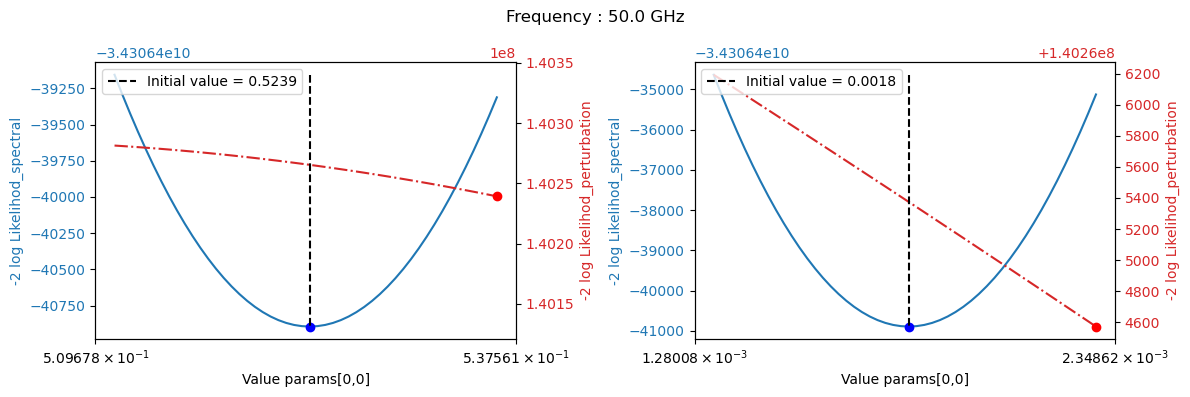

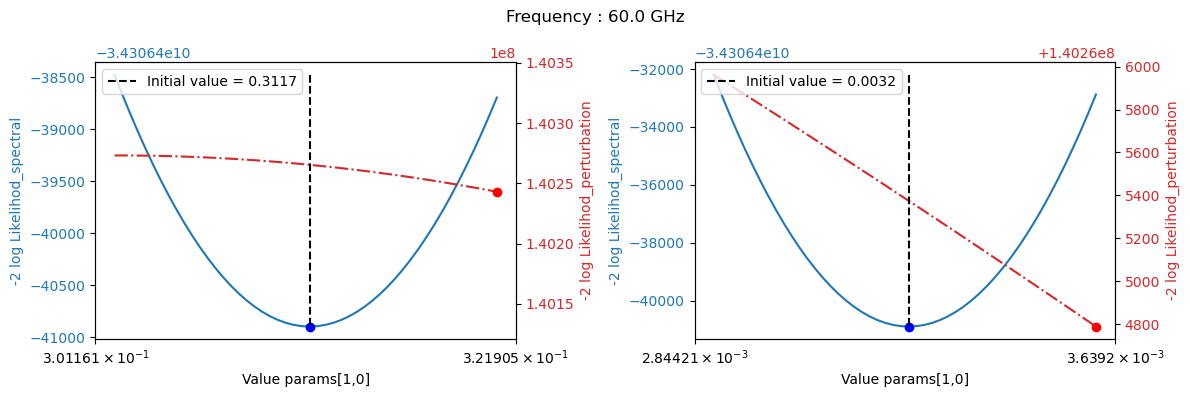

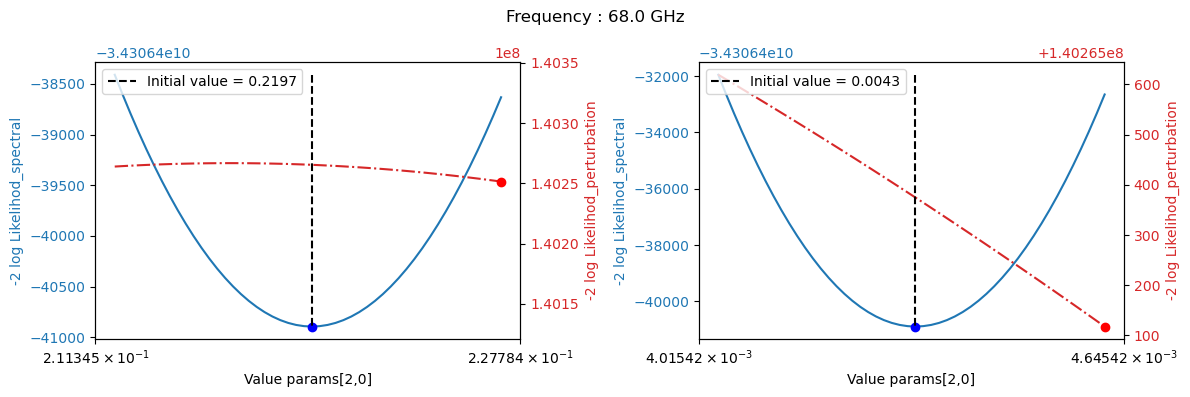

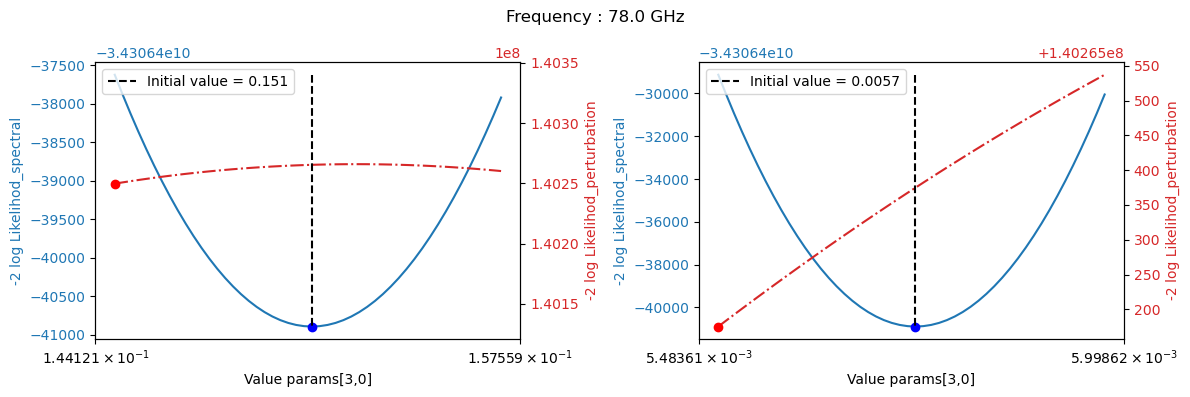

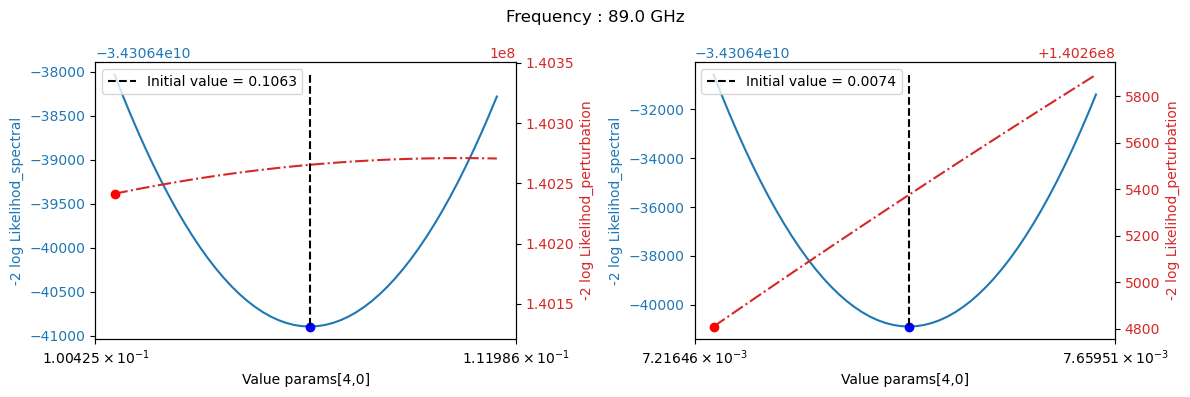

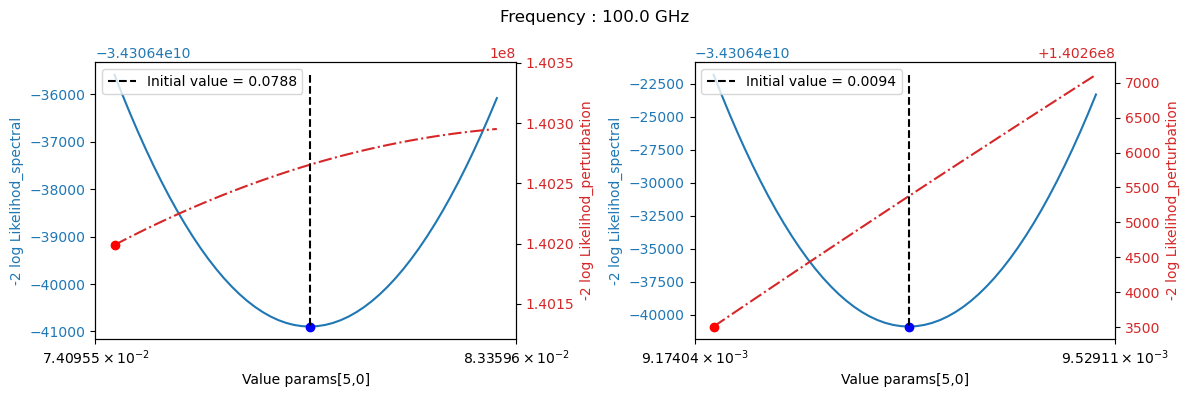

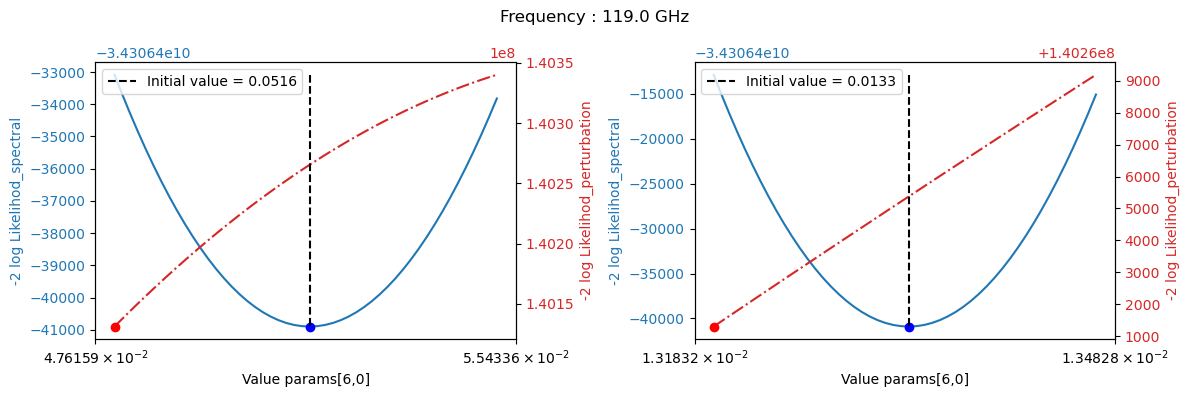

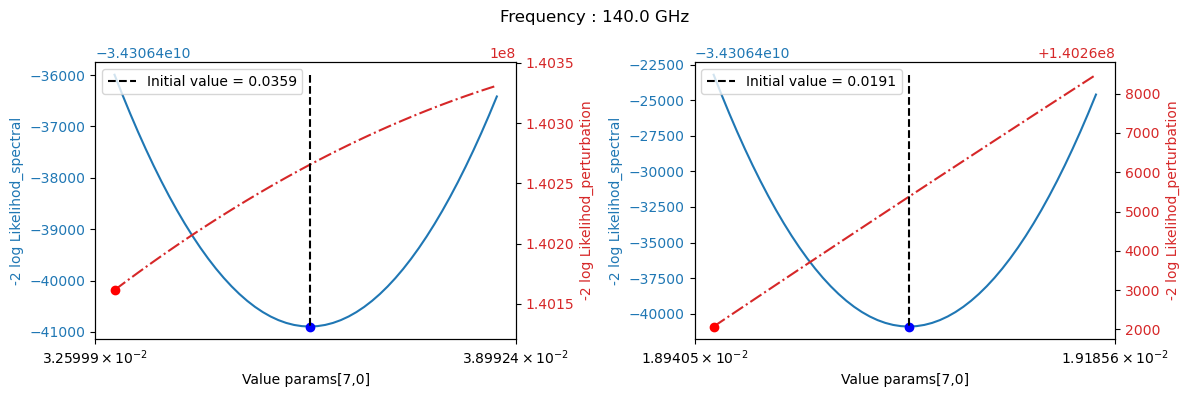

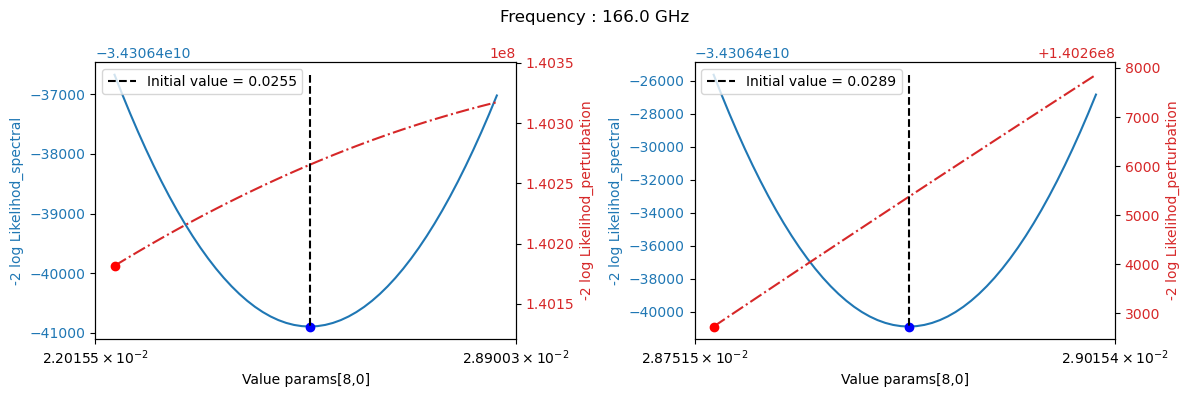

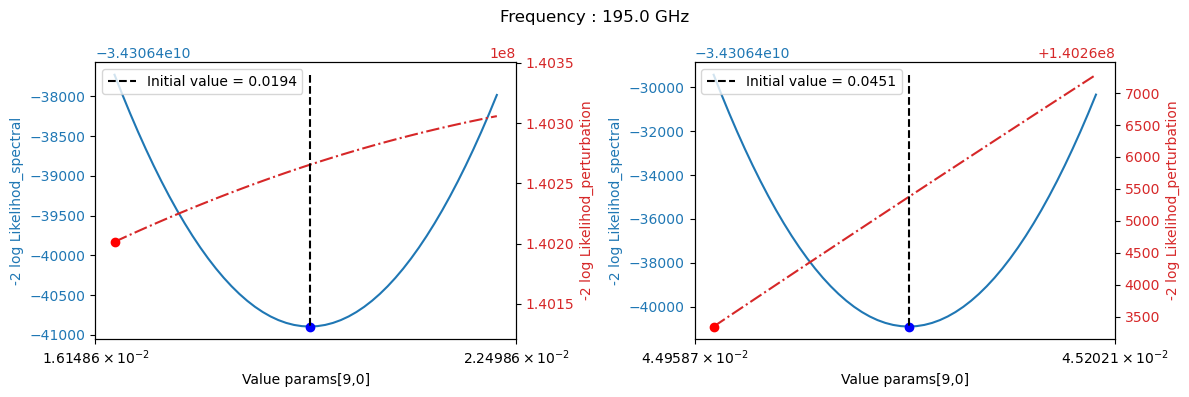

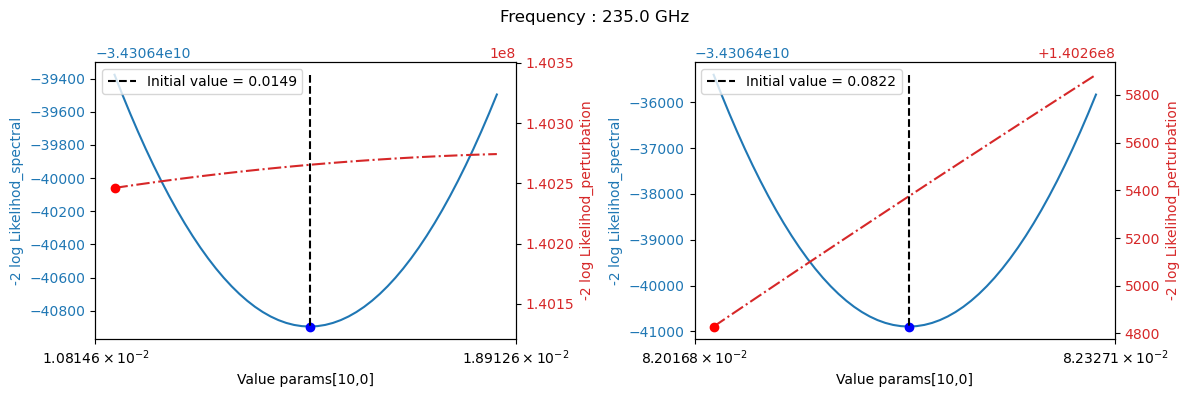

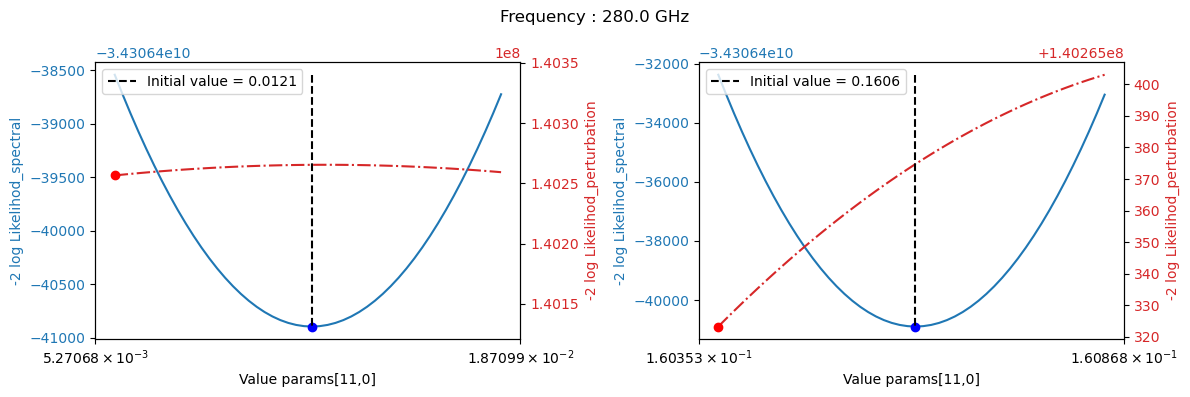

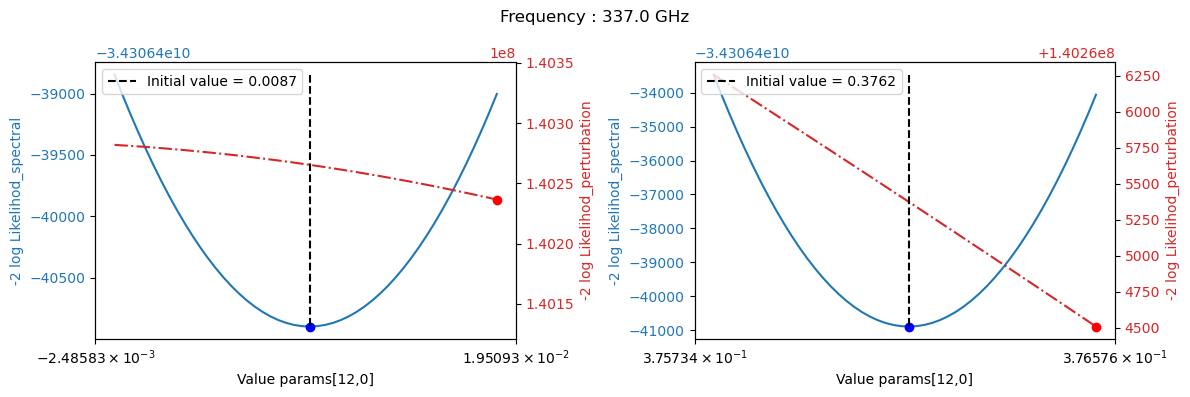

In [85]:
log_proba_griding_synch_fine = np.array(log_proba_samples_synch_list_fine)#-regularization_constant
log_proba_griding_dust_fine = np.array(log_proba_samples_dust_list_fine)#-regularization_constant

log_proba_griding_synch_perturbation_fine = np.array(log_proba_samples_synch_perturbation_proba_fine)#-regularization_constant
log_proba_griding_dust_perturbation_fine = np.array(log_proba_samples_dust_perturbation_proba_fine)#-regularization_constant

nb_Fisher = 5

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    # plt.figure(figsize=(15,4))
    
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    # fig, ax_array = plt.subplot(121)
    fig, ax_array = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    plt.suptitle('Frequency : {} GHz'.format(frequency_Bf[freq_coord+1]))
    # min_value = (-2*log_proba_griding_synch[freq_coord,:]).min()

    # plt.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_fine[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_full_fine[freq_coord,:], '-.', label='Full -2log-likelihood')
    ax1_1 = ax_array[0]
    ax1_1.set_xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    ax1_1.set_xscale('symlog')
    ax1_1.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_fine[freq_coord,:], color='tab:blue', label='Spectral -2log-likelihood')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')
    true_min_log_value = np.min(-2*log_proba_griding_synch_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_synch_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_1.plot([griding_logspace_fine[0,freq_coord,value_Bf_min]],[true_min_log_value],'o', color='blue')

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_perturbation', color='tab:red')  # we already handled the x-label with ax1
    # ax1_2.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_full_fine[freq_coord,:], '-.', color='tab:red', label='Full -2log-likelihood')
    ax1_2.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_synch_perturbation_fine[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    true_min_log_value = np.min(-2*log_proba_griding_synch_perturbation_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_synch_perturbation_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_2.plot([griding_logspace_fine[0,freq_coord,value_Bf_min]],[true_min_log_value],'o', color='red')
    
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    # min_value = max(-2*log_proba_griding_synch_fine[freq_coord,:].min(),-2*log_proba_griding_synch_full_fine[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_synch_fine[freq_coord,:].max(),-2*log_proba_griding_synch_full_fine[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_fine.min(),-2*log_proba_griding_synch_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_synch[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    min_value = -2*log_proba_griding_synch_full_fine[freq_coord,:].min()
    max_value = -2*log_proba_griding_synch_full_fine[freq_coord,:].max()
    plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_perturbation_fine.min(),-2*log_proba_griding_synch_perturbation_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # ax1_2.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    


    # sigma_B_f = nb_Fisher*np.diag(minimum_std_Fisher)[freq_coord]
    # half_value = -np.median(log_proba_griding_synch[freq_coord,:])/2
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=r"$\sigma (B_{f})$"+f"~{percent_value}%")
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=f"{nb_Fisher}"+r"$\sigma_{Fisher}$")

    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with synch')
    plt.legend(loc='upper left')

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    
    
    # plt.subplot(122)
    # plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_fine[freq_coord,:], label='Spectral -2log-likelihood')
    # plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_full_fine[freq_coord,:], '-.', label='Full -2 log-likelihood')

    ax1_1 = ax_array[1]
    ax1_1.set_xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord))
    ax1_1.set_ylabel('-2 log Likelihod_spectral', color='tab:blue')
    ax1_1.set_xscale('symlog')
    ax1_1.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_fine[freq_coord,:], color='tab:blue')
    ax1_1.tick_params(axis='y', labelcolor='tab:blue')
    true_min_log_value = np.min(-2*log_proba_griding_dust_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_dust_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_1.plot([griding_logspace_fine[1,freq_coord,value_Bf_min]],[true_min_log_value],'o', color='blue')

    ax1_2 = ax1_1.twinx()
    ax1_2.set_ylabel('-2 log Likelihod_perturbation', color='tab:red')  # we already handled the x-label with ax1
    ax1_2.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_dust_perturbation_fine[freq_coord,:], '-.', color='tab:red')
    ax1_2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    true_min_log_value = np.min(-2*log_proba_griding_dust_perturbation_fine[freq_coord,:])
    value_Bf_min = np.where(-2*log_proba_griding_dust_perturbation_fine[freq_coord,:] == true_min_log_value)[0]
    ax1_2.plot([griding_logspace_fine[1,freq_coord,value_Bf_min]],[true_min_log_value],'o', color='red')
    # min_value = max(-2*log_proba_griding_dust_fine[freq_coord,:].min(),-2*log_proba_griding_dust_full_fine[freq_coord,:].min())
    # max_value = min(-2*log_proba_griding_dust_fine[freq_coord,:].max(),-2*log_proba_griding_dust_full_fine[freq_coord,:].max())
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full.min(),-2*log_proba_griding_dust_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full_fine.min(),-2*log_proba_griding_dust_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    initial_value_pysm = np.round(init_param_pysm[freq_coord,cpt_coord+1], decimals=n_decimals)
    # plt.plot([initial_value_pysm,initial_value_pysm], [min_value,max_value], 'r-.', label='Pysm value = {}'.format(initial_value_rounded))

    min_value = -2*log_proba_griding_dust_perturbation_fine[freq_coord,:].min()
    max_value = -2*log_proba_griding_dust_perturbation_fine[freq_coord,:].max()
    ax1_2.plot([initial_value,initial_value], [min_value, max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    
    
    # plt.xscale('symlog')
    # plt.xlabel('Value params[{},{}]'.format(freq_coord, cpt_coord+1))
    # plt.ylabel('-2 log Likelihod_spectral')
    # plt.title('Probing full likelihood with dust')
    # # plt.xlim(xmin=.5*initial_value, xmax=1.5*initial_value)
    plt.legend(loc='upper left')
    plt.show()


# MCMC

In [ ]:
with_prints = False

number_steps_sampler = 10000
n_walkers = 1

kernel = MetropolisHastings_log(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.1)
# kernel = MetropolisHastings(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.1)
# kernel = MetropolisHastings(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.5)
# kernel = MetropolisHastings(jitted_new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


In [ ]:
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='init synch values')
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='init dust values')

plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, '-.', label='init synch pre-sampling')
plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, '-.', label='init dust pre-sampling')
plt.loglog()
plt.legend()
plt.title('Initial guess values')
plt.show()

In [ ]:
%%time 
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints, regularization_constant=regularization_constant)
samples = mcmc.get_samples(group_by_chain=True)
mcmc.print_summary()


sample: 100%|██████████| 50000/50000 [02:54<00:00, 287.22it/s]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[1]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[2]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[3]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[4]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[5]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[6]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[7]      0.02      0.00      0.02      0.02      0.02      0.50      1.00
 Param:0[8]      0.03      0.00      0.03      0.03      0.03      0.50      1.00
 Param:0[9]      0.05      0.00      0.05      0.05      0.05      0.50      1.00
Param:0[10]      0.08      0.00      0.08      0.08      0.08      0.50      1.00
Param:0[11]    

In [ ]:
samples.shape

(1, 50000, 26)

In [ ]:
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(samples[0,i,0,:], pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for i in range(number_steps_sampler)]
log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(samples[0,i,:], pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for i in range(number_steps_sampler)]

In [ ]:
log_proba_samples = np.array(log_proba_samples_list)/log_proba_samples_list[0]

In [ ]:
# number_element_column = int(samples.shape[2]/2)

number_element_column = int(samples.shape[-1]/2)
# component_synch = samples[:,:,:,:number_element_column].reshape(number_steps_sampler, number_element_column)
# component_dust = samples[:,:,:,number_element_column:].reshape(number_steps_sampler, number_element_column)
# # component_dust = samples[:,:,:,number_element_column:].reshape(number_steps_sampler, number_element_column, order='F')

component_synch = samples[:,:,:number_element_column].reshape(number_steps_sampler, number_element_column)
component_dust = samples[:,:,number_element_column:].reshape(number_steps_sampler, number_element_column)


print(component_synch.shape)

(50000, 13)


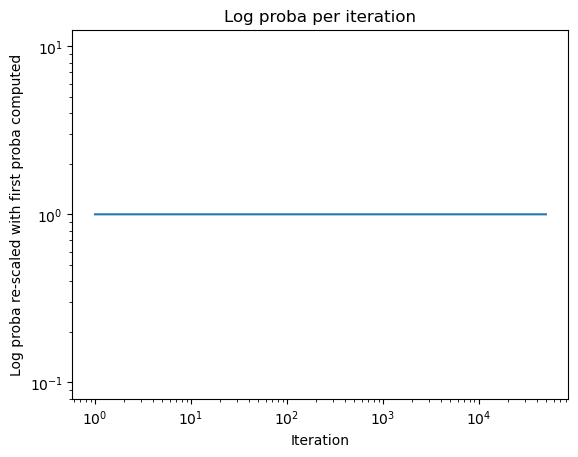

In [ ]:
plt.plot(np.arange(number_steps_sampler)+1, log_proba_samples)
plt.title('Log proba per iteration')
plt.xlabel('Iteration')
plt.ylabel('Log proba re-scaled with first proba computed')
plt.loglog()
plt.show()

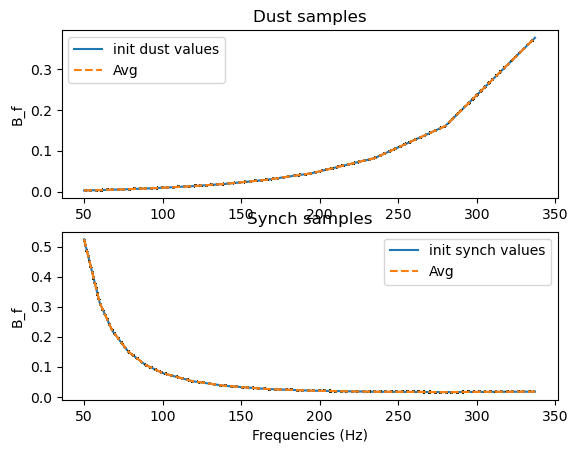

In [ ]:
frequency_Bf = instrument['frequency'][1:-1]

plt.subplot(211)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='init synch values')
plt.plot(frequency_Bf, component_synch.T, ':', alpha=0.1)
plt.plot(frequency_Bf, component_synch.mean(axis=0), '--', label='Avg')
# plt.plot(frequency_Bf, component_synch[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_synch[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_synch[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('synch samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')

plt.subplot(212)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='init dust values')
plt.plot(frequency_Bf, component_dust.T, ':', alpha=0.1)
plt.plot(frequency_Bf, component_dust.mean(axis=0), '--', label='Avg')
# plt.plot(frequency_Bf, component_synch[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_synch[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_synch[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('dust samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')
plt.show()

In [ ]:
number_element_column = int(samples.shape[-1]/2)


# all_ess = numpyro.diagnostics.effective_sample_size(samples[:,:,0,:])
all_ess = numpyro.diagnostics.effective_sample_size(samples[:,:,:])
print(all_ess.shape)
print(all_ess)

int_ess = np.where(np.int32(np.round(all_ess)) == 0, 1, np.int32(np.round(all_ess)))

all_samples_ESS = []
all_avg_ESS = np.empty(samples.shape[-1])
for i in range(samples.shape[-1]):
    # all_samples_ESS.append(samples[0,::int_ess[i],0,i])
    # all_avg_ESS[i] = np.average(samples[0,::int_ess[i],0,i])
    all_samples_ESS.append(samples[0,::int_ess[i],i])
    all_avg_ESS[i] = np.average(samples[0,::int_ess[i],i])


(26,)
[0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005]


In [ ]:
for i in range(len(all_samples_ESS)):
    print('Std :', np.std(all_samples_ESS[i]))

Std : 3.903127820947816e-18
Std : 5.204170427930421e-18
Std : 1.734723475976807e-18
Std : 6.938893903907228e-18
Std : 3.469446951953614e-18
Std : 1.734723475976807e-18
Std : 1.9081958235744878e-17
Std : 2.42861286636753e-17
Std : 3.122502256758253e-17
Std : 0.0
Std : 1.1102230246251565e-16
Std : 1.3877787807814457e-16
Std : 1.1102230246251565e-16
Std : 7.771561172376096e-16
Std : 3.885780586188048e-16
Std : 1.6653345369377348e-16
Std : 0.0
Std : 5.551115123125783e-17
Std : 2.7755575615628914e-17
Std : 7.632783294297951e-17
Std : 4.163336342344337e-17
Std : 3.122502256758253e-17
Std : 0.0
Std : 1.734723475976807e-17
Std : 3.469446951953614e-18
Std : 1.734723475976807e-17


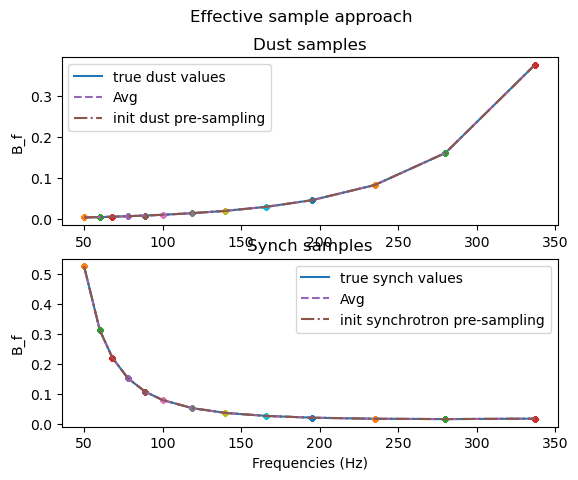

In [ ]:
alpha_value = 0.5

frequency_Bf = instrument['frequency'][1:-1]
plt.suptitle("Effective sample approach")
plt.subplot(211)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='true synch values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, all_avg_ESS[:number_element_column], '--', label='Avg')
plt.plot(frequency_Bf, full_initial_guess[:int(dimensions_mixing_matrix/2)].T, '-.', label='init synch pre-sampling')
# plt.plot(frequency_Bf, component_synch[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_synch[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_synch[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('synch samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')

plt.subplot(212)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='true dust values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, all_avg_ESS[number_element_column:], '--', label='Avg')
plt.plot(frequency_Bf, full_initial_guess[int(dimensions_mixing_matrix/2):].T, '-.', label='init dust pre-sampling')
# plt.plot(frequency_Bf, component_synch[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_synch[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_synch[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('dust samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')
plt.show()

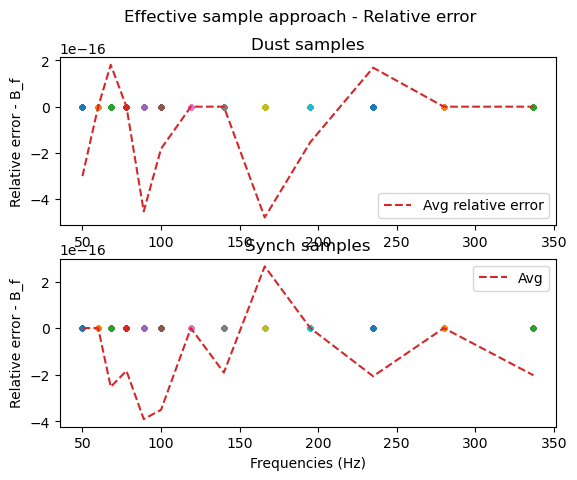

In [ ]:
alpha_value = 0.5

frequency_Bf = instrument['frequency'][1:-1]
plt.suptitle("Effective sample approach - Relative error")
plt.subplot(211)
true_values = initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T
# plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='true synch values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), (all_samples_ESS[i]-true_values[i])/true_values[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, (all_avg_ESS[:number_element_column]-true_values)/true_values, '--', label='Avg relative error')
# plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, '-.', label='init synch pre-sampling')
# plt.plot(frequency_Bf, component_synch[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_synch[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_synch[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('synch samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('Relative error - B_f')

plt.subplot(212)
true_values = initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T
# plt.plot(frequency_Bf, true_values, label='true dust values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), (all_samples_ESS[number_element_column+i]-true_values[i])/true_values[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, (all_avg_ESS[number_element_column:]-true_values)/true_values, '--', label='Avg')
# plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, '-.', label='init dust pre-sampling')
# plt.plot(frequency_Bf, component_synch[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_synch[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_synch[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('dust samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Relative error - B_f')
plt.show()

In [ ]:
# # ver = 'J1a'
# # filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
# # np.save(filename_backend_mcmc, samples_chain)

# ver = 'J0a'
# filename_backend_mcmc = "validation_numpyro_spectral_LKLD_{}_{}ver{}".format(instr_name, nside,ver)
# np.save(filename_backend_mcmc, samples_chain)

In [ ]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [ ]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)
gelman_rubin_statistic

(8,)


array([ 2.37004277,  1.11387337,  4.00558247,  1.08546988,  4.27636892,
        1.00271842,  2.97649006, 13.27488369])

In [ ]:
gelman_rubin_statistic_0 = numpyro.diagnostics.gelman_rubin(np.mean(chain_samples,axis=2))
print(gelman_rubin_statistic_0.shape)
gelman_rubin_statistic_0

()


4.173108189485061

In [ ]:
gelman_rubin_statistic_2 = numpyro.diagnostics.gelman_rubin(chain_samples[:2])
print(gelman_rubin_statistic_2.shape)
gelman_rubin_statistic_2

(8,)


array([1.28471094, 2.42021836, 2.58464444, 2.02191194, 1.07191771,
       3.42065517, 2.39569205, 2.58386433])

In [ ]:
autocovariance.shape

(700, 1, 8)

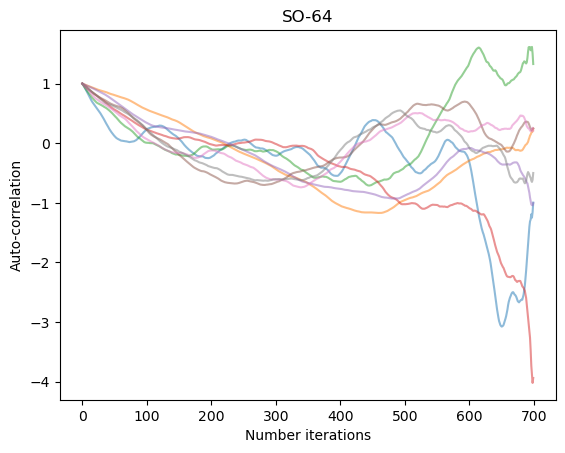

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

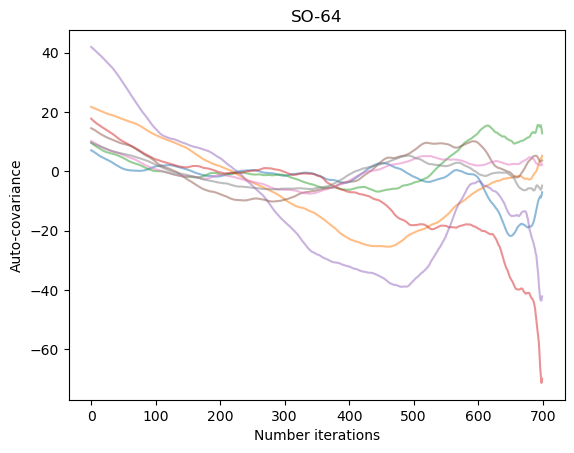

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', BtinvNB, BtinvN, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)